# setup dataset

In [1]:
# import stuff
import os
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm_notebook as tqdm

import torch
import torch.utils.data as data
from itertools import product as product

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Function

In [2]:
# make dirs
os.makedirs("log", exist_ok=True)
os.makedirs("weights", exist_ok=True)

In [3]:
# import dataset
from utils.dataset import VOCDataset, DatasetTransform, make_datapath_list, Anno_xml2list, od_collate_fn

In [4]:
## meta settings
import pretrainedmodels
model_name = 'resnet18' # choose from any resnets
DATASET = "VOC"
retina = False # for trying retinanets
fpn = False # try for fpns
HALF = False
scale = 1

In [5]:
num_class = 20 # for VOC
batch_size = 32
input_size = 512 # should be dividable with 32
MODEL_SCALE = 8 # output heatmap scale

## make data.Dataset for training

In [6]:
# load files
# set your VOCdevkit path here.
vocpath = "../VOCdevkit/VOC2007"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(vocpath)

vocpath = "../VOCdevkit/VOC2012"
train_img_list2, train_anno_list2, _, _ = make_datapath_list(vocpath)

train_img_list.extend(train_img_list2)
train_anno_list.extend(train_anno_list2)

print("trainlist: ", len(train_img_list))
print("vallist: ", len(val_img_list))

# make Dataset
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

## DatasetTransform
transform = DatasetTransform(input_size)
transform_anno = Anno_xml2list(voc_classes)

# Dataloader
train_dataset = VOCDataset(train_img_list, train_anno_list, phase = "train", transform=transform, transform_anno = transform_anno)
val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DatasetTransform(
    input_size), transform_anno=Anno_xml2list(voc_classes))

trainlist:  16551
vallist:  4952


In [7]:
# confirm operation
images, targets = val_dataset[0]

# Encode box information to heatmaps for Centernet

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


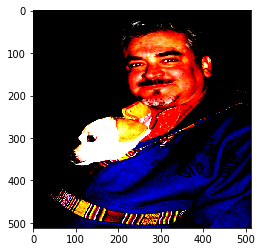

In [8]:
# show image
img = images.numpy()
plt.imshow(img.transpose(1,2,0))

In [9]:
# show targets
target = np.asarray(targets)
print(target)
# convert targets to its center.
center = np.asarray([np.mean(np.asarray([target[:,2],target[:,0]]), axis=0).T, np.mean(np.asarray([target[:,3],target[:,1]]), axis=0).T, target[:,4]]).T
center

[[ 0.13314448  0.478       0.54957507  0.74       11.        ]
 [ 0.01983003  0.022       0.99433428  0.994      14.        ]]


array([[ 0.34135977,  0.609     , 11.        ],
       [ 0.50708215,  0.508     , 14.        ]])

In [10]:
img -= np.min(img)

plot center points


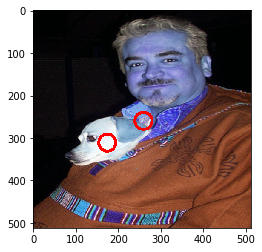

In [11]:
# Let's see if the center is encoded right

img2 = cv2.imread("../VOCdevkit/VOC2007/JPEGImages/000001.jpg")
img2 = cv2.resize(img2, (input_size, input_size))

# plot stuff centers
for c in center:
    img2 = cv2.circle(img2, (int(c[0]*input_size), int(c[1]*input_size)), 20, (255, 0, 0), 5)

print("plot center points")
plt.imshow(img2/255)
plt.show()
plt.imsave("imgs/center", img2/255)

The center is encoded right!

Now, we make the heatmaps so that centernet can train to predict centers.

In [12]:
# from centernet repo
def draw_msra_gaussian(heatmap, center, sigma=2):
  tmp_size = sigma * 6
  mu_x = int(center[0] + 0.5)
  mu_y = int(center[1] + 0.5)
  w, h = heatmap.shape[0], heatmap.shape[1]
  ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
  br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
  if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
    return heatmap
  size = 2 * tmp_size + 1
  x = np.arange(0, size, 1, np.float32)
  y = x[:, np.newaxis]
  x0 = y0 = size // 2
  g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
  g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
  g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
  img_x = max(0, ul[0]), min(br[0], h)
  img_y = max(0, ul[1]), min(br[1], w)
  heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
    g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
  return heatmap

def draw_dense_reg(regmap, heatmap, center, value, radius, is_offset=False):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  value = np.array(value, dtype=np.float32).reshape(-1, 1, 1)
  dim = value.shape[0]
  reg = np.ones((dim, diameter*2+1, diameter*2+1), dtype=np.float32) * value
  if is_offset and dim == 2:
    delta = np.arange(diameter*2+1) - radius
    reg[0] = reg[0] - delta.reshape(1, -1)
    reg[1] = reg[1] - delta.reshape(-1, 1)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]
    
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
  masked_regmap = regmap[:, y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom,
                             radius - left:radius + right]
  masked_reg = reg[:, radius - top:radius + bottom,
                      radius - left:radius + right]
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    idx = (masked_gaussian >= masked_heatmap).reshape(
      1, masked_gaussian.shape[0], masked_gaussian.shape[1])
    masked_regmap = (1-idx) * masked_regmap + idx * masked_reg
  regmap[:, y - top:y + bottom, x - left:x + right] = masked_regmap
  return regmap

def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

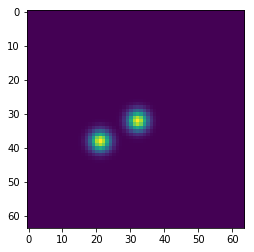

In [13]:
# make output heatmap for single class
hm = np.zeros([input_size//MODEL_SCALE, input_size//MODEL_SCALE])

# show targets
target = np.asarray(targets)
# convert targets to its center.
center = np.asarray([np.mean(np.asarray([target[:,2],target[:,0]]), axis=0).T, \
                     np.mean(np.asarray([target[:,3],target[:,1]]), axis=0).T, target[:,4]]).T

# make a center point
# try gaussian points.
for c in center:
    #hm[int(c[0]*input_size)//MODEL_SCALE, int(c[1]*input_size)//MODEL_SCALE] = 1
    hm = draw_msra_gaussian(hm, [int(c[0]*input_size)//MODEL_SCALE, int(c[1]*input_size)//MODEL_SCALE])
    
# plot and confirm if its working
plt.imshow(hm)
plt.show()

### make output heatmap for each class

heatmap of person class


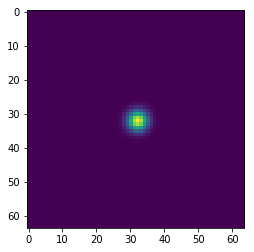

In [14]:
hm = np.zeros([num_class, input_size//MODEL_SCALE, input_size//MODEL_SCALE])

# show targets
target = np.asarray(targets)
# convert targets to its center.
center = np.asarray([np.mean(np.asarray([target[:,2],target[:,0]]), axis=0).T, \
                     np.mean(np.asarray([target[:,3],target[:,1]]), axis=0).T, target[:,4].astype(int)]).T

# make a center point
# try gaussian points.
for c in center:
    mask = hm[int(c[2]), :, :]
    mask = draw_msra_gaussian(mask, [int(c[0]*input_size)//MODEL_SCALE, int(c[1]*input_size)//MODEL_SCALE])
    hm[int(c[2]), :, :] = mask
    
# plot and confirm if its working
print("heatmap of person class")
plt.imshow(hm[14])
plt.show()

### make regression targets.

[[ 0.13314448  0.478       0.54957507  0.74       11.        ]
 [ 0.01983003  0.022       0.99433428  0.994      14.        ]]
show regr


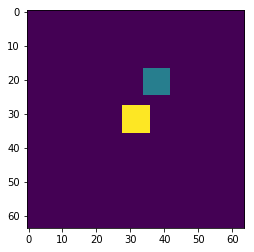

In [15]:
# [width_size, height_size]

# make regr heatmap 
regr = np.zeros([2, input_size//MODEL_SCALE, input_size//MODEL_SCALE])

# show targets
target = np.asarray(targets)
print(target)
# convert targets to its center.
regrs = np.asarray([np.asarray([target[:,2]-target[:,0]]), \
                     np.asarray([target[:,3]-target[:,1]])]).T

# plot regr values to mask
for r, c in zip(regrs, center):
    y, x = int(c[0]*input_size)//MODEL_SCALE, int(c[1]*input_size)//MODEL_SCALE
    for i in range(-4, 4):
        for j in range(-4, 4):
            regr[:, int(c[0]*input_size)//MODEL_SCALE+i, int(c[1]*input_size)//MODEL_SCALE+j] = r
    #regr = draw_dense_reg(regr, center, [y,x], regrs, 0, False)

print("show regr")
plt.imshow(regr[0])
plt.show()

In [16]:
regr.shape

(2, 64, 64)

In [17]:
# wrap as function
def make_hm(target, input_size=512, num_class=20):
    # make output heatmap for each class
    hm = np.zeros([num_class, input_size//MODEL_SCALE, input_size//MODEL_SCALE])
    # make regr heatmap 
    regr = np.zeros([2, input_size//MODEL_SCALE, input_size//MODEL_SCALE])

    # convert targets to its center.
    center = np.asarray([np.mean(np.asarray([target[:,2],target[:,0]]), axis=0).T, \
                         np.mean(np.asarray([target[:,3],target[:,1]]), axis=0).T, target[:,4].astype(int)]).T
    regrs = np.asarray([np.asarray([target[:,2]-target[:,0]]), \
                     np.asarray([target[:,3]-target[:,1]])]).T

    # make masks
    for r, c in zip(regrs, center):
        mask = hm[int(c[2]), :, :]
        mask = draw_msra_gaussian(mask, [int(c[0]*input_size)//MODEL_SCALE, int(c[1]*input_size)//MODEL_SCALE])
        hm[int(c[2]), :, :] = mask
        for i in range(-3, 4):
            for j in range(-3, 4):
                xx = np.clip(int(c[0]*input_size)//MODEL_SCALE+i, 0, input_size//MODEL_SCALE-1)
                yy = np.clip(int(c[1]*input_size)//MODEL_SCALE+j, 0, input_size//MODEL_SCALE-1)
                regr[:, yy, xx] = r
    return hm, regr

# define dataloaders

In [18]:
class centerVOCDataset(data.Dataset):
    def __init__(self, img_list, anno_list, phase, transform, transform_anno, input_size=512):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform
        self.transform_anno = transform_anno
        self.input_size = input_size
        
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        im, hm, regr = self.pull_item(index)
        #print(im.shape)
        #print(hm.shape)
        #print(regr.shape)
        return im, hm, regr
    
    def pull_item(self, index):
        # 1. read image
        img_path = self.img_list[index]
        img = cv2.imread(img_path)
        height, width, channel = img.shape
        
        # 2. read annotations
        xml_path = self.anno_list[index]
        anno_list = self.transform_anno(xml_path, width, height)
        
        # 3. augumentations
        img, boxes, labels = self.transform(img, self.phase, anno_list[:, :4], anno_list[:, 4])
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))
        
        # 4. transform BGR to RGB
        img = torch.from_numpy(img[:, :, (2, 1, 0)])
        img = img.permute(2, 0, 1)
        
        # 5. convert boxes inforatmion to heatmaps
        hm, regr = make_hm(gt, self.input_size)
        
        return img, hm, regr

In [19]:
# test dataloader
# call dataset
train_dataset2 = centerVOCDataset(train_img_list, train_anno_list, phase = "train", transform=transform, transform_anno = transform_anno, input_size=input_size)
val_dataset2 = centerVOCDataset(val_img_list, val_anno_list, phase="val", transform=DatasetTransform(
    input_size), transform_anno=Anno_xml2list(voc_classes), input_size=input_size)

# dataloader
train_dataloader = data.DataLoader(
    train_dataset2, batch_size=batch_size, shuffle=True, num_workers=8)
val_dataloader = data.DataLoader(
    val_dataset2, batch_size=batch_size, shuffle=False, num_workers=8)
# as dict
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

im


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


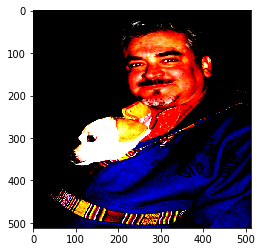

heatmap


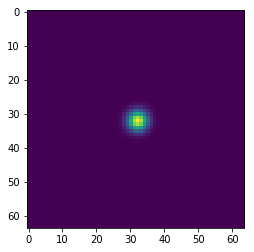

regr


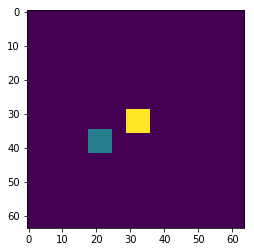

In [20]:
# confirm operation
im, hm, regr = val_dataset2[0]
print("im")
plt.imshow(im.numpy().transpose(1,2,0))
plt.show()
print("heatmap")
plt.imshow(hm[14])
plt.show()
print("regr")
plt.imshow(regr[0])
plt.show()

In [21]:
im.shape

torch.Size([3, 512, 512])

In [22]:
np.concatenate([hm,regr]).shape

(22, 64, 64)

# define Centernet model and test

In [23]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch)
        
    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
            # input is CHW
            diffY = x2.size()[2] - x1.size()[2]
            diffX = x2.size()[3] - x1.size()[3]

            x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                            diffY // 2, diffY - diffY//2))
        else:
            x = x1
        x = self.conv(x)
        return x

In [24]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo

# create backbone.
basemodel = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
basemodel = nn.Sequential(*list(basemodel.children())[:-2])

In [25]:
class centernet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(centernet, self).__init__()
        self.base_model = basemodel
        
        if model_name == "resnet34" or model_name=="resnet18":
            num_ch = 512
        else:
            num_ch = 2048
        
        self.up1 = up(num_ch, 512)
        self.up2 = up(512, 256)
        self.up3 = up(256, 256)
        # output classification
        self.outc = nn.Conv2d(256, n_classes, 1)
        # output residue
        self.outr = nn.Conv2d(256, 2, 1)
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.base_model(x)
        
        # Add positional info        
        x = self.up1(x)
        x = self.up2(x)
        #x = self.up3(x)
        outc = self.outc(x)
        outr = self.outr(x)
        return outc, outr

In [26]:
# test if net works
model = centernet(num_class) # +2 for width and height regressions
print(torch.rand([1,3,input_size,input_size]).size())
outc, outr = model(torch.rand([1,3,input_size,input_size]))
print(outc.size())
print(outr.size())

torch.Size([1, 3, 512, 512])
torch.Size([1, 20, 64, 64])
torch.Size([1, 2, 64, 64])


# set up optimizers

In [27]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## setup focal loss

In [28]:
# focal loss
def neg_loss(pred, gt):
  ''' Modified focal loss. Exactly the same as CornerNet.
      Runs faster and costs a little bit more memory
    Arguments:
      pred (batch x c x h x w)
      gt_regr (batch x c x h x w)
  '''
  pred = pred.unsqueeze(1).float()
  gt = gt.unsqueeze(1).float()

  pos_inds = gt.eq(1).float()
  neg_inds = gt.lt(1).float()
  neg_weights = torch.pow(1 - gt, 4)

  loss = 0

  pos_loss = torch.log(pred + 1e-12) * torch.pow(1 - pred, 2) * pos_inds
  neg_loss = torch.log(1 - pred + 1e-12) * torch.pow(pred, 2) * neg_weights * neg_inds

  num_pos  = pos_inds.float().sum()
  pos_loss = pos_loss.sum()
  neg_loss = neg_loss.sum()

  if num_pos == 0:
    loss = loss - neg_loss
  else:
    loss = loss - (pos_loss + neg_loss) / num_pos
  return loss

def _reg_loss(regr, gt_regr, mask):
  ''' L1 regression loss
    Arguments:
      regr (batch x max_objects x dim)
      gt_regr (batch x max_objects x dim)
      mask (batch x max_objects)
  '''
  num = mask.float().sum()
  #print(gt_regr.size())
  mask = mask.sum(1).unsqueeze(1).expand_as(gt_regr)
  #print(mask.size())

  regr = regr * mask
  gt_regr = gt_regr * mask
    
  regr_loss = nn.functional.smooth_l1_loss(regr, gt_regr, size_average=False)
  regr_loss = regr_loss / (num + 1e-4)
  return regr_loss

def criterion(pred_mask, pred_regr, mask, regr, weight=0.4, size_average=True, num_class=20):
    # Binary mask loss
    pred_mask = torch.sigmoid(pred_mask) # class masks
    mask_loss = neg_loss(pred_mask, mask)
    
    sum=np.sum(mask.cpu().numpy()==1)
    
    # Regression L1 loss
    regr_loss = _reg_loss(pred_regr, regr, mask)
  
    # Sum
    loss = mask_loss +regr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss ,mask_loss , regr_loss

In [29]:
# while the original efficientdet uses cosine annealining lr scheduling, we utilize epoch-based lr decreasing for simplicity.
def get_current_lr(epoch): 
    reduce = [80,120]
    lr = 1e-3        
    for i,lr_decay_epoch in enumerate(reduce):
        if epoch >= lr_decay_epoch:
            lr *= 0.1
    return lr

def adjust_learning_rate(optimizer, epoch):
    lr = get_current_lr(epoch)
    print("lr is:", lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [30]:
# pool duplicates
def pool(data):
    stride = 3
    for y in np.arange(1,data.shape[1]-1, stride):
        for x in np.arange(1, data.shape[0]-1, stride):
            a_2d = data[x-1:x+2, y-1:y+2]
            max = np.asarray(np.unravel_index(np.argmax(a_2d), a_2d.shape))
            
            for c1 in range(3):
                for c2 in range(3):
                    #print(c1,c2)
                    if not (c1== max[0] and c2 == max[1]):
                        data[x+c1-1, y+c2-1] = -1
    return data

# set up train and eval scripts

In [31]:
# train script. nothing special..
import gc
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs):
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("used device:", device)

    # ネットワークをGPUへ
    model.to(device)
    torch.backends.cudnn.benchmark = True

    # イテレーションカウンタをセット
    iteration = 1
    epoch_train_loss = 0.0  # epochの損失和
    epoch_val_loss = 0.0  # epochの損失和
    logs = []

    # epochのループ
    for epoch in range(num_epochs+1):
        
        adjust_learning_rate(optimizer, epoch)
        
        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # モデルを訓練モードに
                print('(train)')
            else:
                if((epoch+1) % 2 == 0):
                    model.eval()   # モデルを検証モードに
                    print('-------------')
                    print('(val)')
                else:
                    # 検証は10回に1回だけ行う
                    continue

            # データローダーからminibatchずつ取り出すループ
            for images, hm, regr in tqdm(dataloaders_dict[phase]):
                # GPUが使えるならGPUにデータを送る
                images = images.to(device)
                hm = hm.to(device)
                regr = regr.to(device)
                
                if HALF:
                    images = images.half()
                    targets = [ann.half() for ann in targets]
                    
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    # 順伝搬（forward）計算
                    mask, mask_regr = model(images)
                    #print(outputs[0].type())
                    # 損失の計算
                    loss, mask_loss, regr_loss = criterion(mask, mask_regr, hm, regr)

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()  # 勾配の計算

                        # 勾配が大きくなりすぎると計算が不安定になるので、clipで最大でも勾配2.0に留める
                        nn.utils.clip_grad_value_(
                            model.parameters(), clip_value=2.0)

                        optimizer.step()  # パラメータ更新

                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('Iter {} || Loss: {:.4f} || Mask: {:.4f} || Regr: {:.4f}'.format(
                                iteration, loss.item(), mask_loss.item(), regr_loss.item()))
                            t_iter_start = time.time()
                        # filter inf..
                        if not loss.item() == float("inf"):
                            epoch_train_loss += loss.item()
                        iteration += 1
                        
                        if iteration%100 == 0:
                            id = 0
                            img, hm, regr = val_dataset2[id]
                            img = img.to(device).unsqueeze(0)
                            with torch.no_grad():
                                hm, regr = model(img)
                            hm = hm.cpu().numpy();regr = regr.cpu().numpy()
                            plt.imshow(hm[0,14])
                            plt.show()
                            plt.imshow(hm[0,14]>0)
                            plt.show()
                            plt.imshow(regr[0,0])
                            plt.show()

                    # 検証時
                    else:
                        if not loss.item() == float("inf"):
                            epoch_val_loss += loss.item()

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss, epoch_val_loss))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        # ログを保存
        log_epoch = {'epoch': epoch+1,
                     'train_loss': epoch_train_loss, 'val_loss': epoch_val_loss}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("log/"+DATASET+"_"+model_name+"_" + str(input_size) +"log_output.csv")

        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和
        gc.collect()

        # ネットワークを保存する
        if((epoch+1) % 10 == 0):
            torch.save(model.state_dict(), 'weights/'+DATASET+"_"+model_name+"_" + str(input_size) + "_" + 
                       str(epoch+1) + '.pth')


used device: cuda:0
lr is: 0.001
-------------
Epoch 1/150
-------------
(train)


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Iter 10 || Loss: 938.5197 || Mask: 938.4402 || Regr: 0.0795
Iter 20 || Loss: 69.8688 || Mask: 69.7867 || Regr: 0.0821
Iter 30 || Loss: 5.7706 || Mask: 5.7152 || Regr: 0.0554
Iter 40 || Loss: 4.0213 || Mask: 3.9707 || Regr: 0.0507
Iter 50 || Loss: 4.1237 || Mask: 4.0670 || Regr: 0.0567
Iter 60 || Loss: 4.1498 || Mask: 4.0998 || Regr: 0.0500
Iter 70 || Loss: 4.0686 || Mask: 4.0274 || Regr: 0.0412
Iter 80 || Loss: 3.8596 || Mask: 3.8222 || Regr: 0.0374
Iter 90 || Loss: 4.2434 || Mask: 4.1880 || Regr: 0.0554


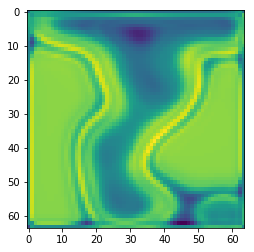

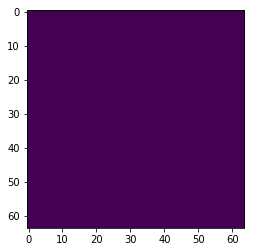

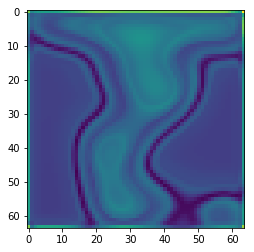

Iter 100 || Loss: 3.9624 || Mask: 3.9126 || Regr: 0.0497
Iter 110 || Loss: 3.9652 || Mask: 3.9166 || Regr: 0.0485
Iter 120 || Loss: 4.1599 || Mask: 4.0885 || Regr: 0.0714
Iter 130 || Loss: 3.9814 || Mask: 3.9282 || Regr: 0.0532
Iter 140 || Loss: 3.8243 || Mask: 3.7773 || Regr: 0.0470
Iter 150 || Loss: 3.7926 || Mask: 3.7542 || Regr: 0.0383
Iter 160 || Loss: 3.8516 || Mask: 3.8073 || Regr: 0.0444
Iter 170 || Loss: 3.8555 || Mask: 3.8117 || Regr: 0.0438
Iter 180 || Loss: 3.8935 || Mask: 3.8427 || Regr: 0.0508
Iter 190 || Loss: 3.9540 || Mask: 3.8994 || Regr: 0.0546


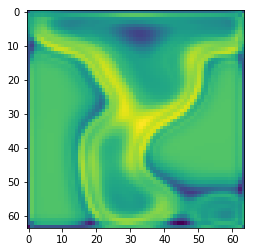

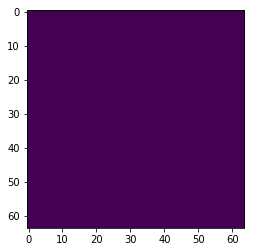

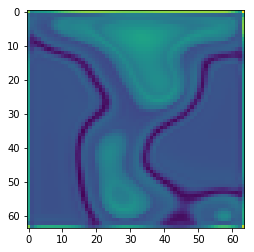

Iter 200 || Loss: 4.0953 || Mask: 4.0526 || Regr: 0.0428
Iter 210 || Loss: 3.7159 || Mask: 3.6720 || Regr: 0.0439
Iter 220 || Loss: 3.9649 || Mask: 3.9196 || Regr: 0.0453
Iter 230 || Loss: 4.0224 || Mask: 3.9773 || Regr: 0.0451
Iter 240 || Loss: 3.9630 || Mask: 3.9100 || Regr: 0.0530
Iter 250 || Loss: 3.7567 || Mask: 3.7111 || Regr: 0.0456
Iter 260 || Loss: 3.6670 || Mask: 3.6260 || Regr: 0.0410
Iter 270 || Loss: 3.7037 || Mask: 3.6597 || Regr: 0.0440
Iter 280 || Loss: 3.6379 || Mask: 3.5827 || Regr: 0.0552
Iter 290 || Loss: 3.8532 || Mask: 3.8083 || Regr: 0.0449


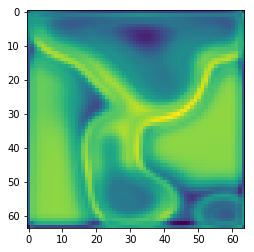

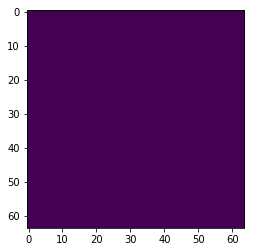

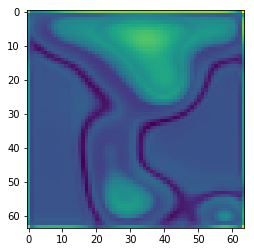

Iter 300 || Loss: 3.8111 || Mask: 3.7676 || Regr: 0.0435
Iter 310 || Loss: 4.0091 || Mask: 3.9480 || Regr: 0.0611
Iter 320 || Loss: 3.5713 || Mask: 3.5280 || Regr: 0.0434
Iter 330 || Loss: 4.0053 || Mask: 3.9301 || Regr: 0.0752
Iter 340 || Loss: 3.6145 || Mask: 3.5699 || Regr: 0.0446
Iter 350 || Loss: 3.7132 || Mask: 3.6731 || Regr: 0.0402
Iter 360 || Loss: 3.6500 || Mask: 3.6081 || Regr: 0.0419
Iter 370 || Loss: 3.7270 || Mask: 3.6822 || Regr: 0.0448
Iter 380 || Loss: 3.6979 || Mask: 3.6515 || Regr: 0.0465
Iter 390 || Loss: 3.6532 || Mask: 3.6146 || Regr: 0.0386


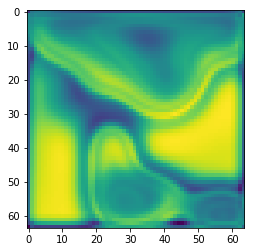

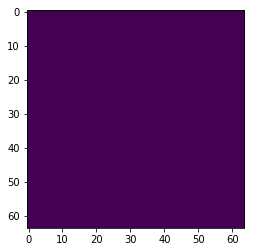

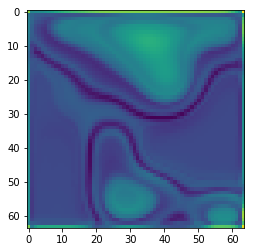

Iter 400 || Loss: 3.6409 || Mask: 3.6011 || Regr: 0.0398
Iter 410 || Loss: 3.6499 || Mask: 3.6028 || Regr: 0.0471
Iter 420 || Loss: 3.5209 || Mask: 3.4740 || Regr: 0.0469
Iter 430 || Loss: 3.7168 || Mask: 3.6713 || Regr: 0.0455
Iter 440 || Loss: 3.6494 || Mask: 3.5968 || Regr: 0.0527
Iter 450 || Loss: 3.7831 || Mask: 3.7482 || Regr: 0.0349
Iter 460 || Loss: 3.5905 || Mask: 3.5558 || Regr: 0.0347
Iter 470 || Loss: 3.7730 || Mask: 3.7198 || Regr: 0.0533
Iter 480 || Loss: 3.6204 || Mask: 3.5697 || Regr: 0.0507
Iter 490 || Loss: 3.8572 || Mask: 3.8117 || Regr: 0.0455


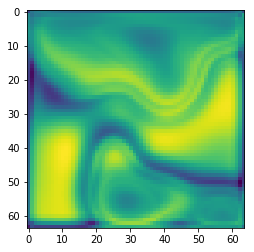

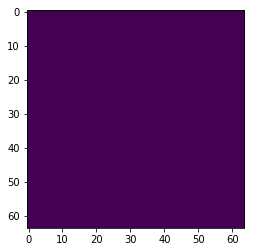

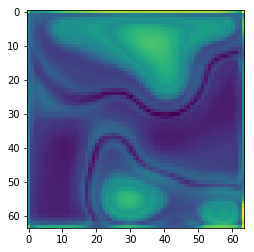

Iter 500 || Loss: 3.8732 || Mask: 3.8224 || Regr: 0.0508
Iter 510 || Loss: 3.8365 || Mask: 3.7929 || Regr: 0.0436

-------------
epoch 1 || Epoch_TRAIN_Loss:50008.4395 ||Epoch_VAL_Loss:0.0000
timer:  156.4139 sec.
lr is: 0.001
-------------
Epoch 2/150
-------------
(train)


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Iter 520 || Loss: 3.6439 || Mask: 3.5945 || Regr: 0.0494
Iter 530 || Loss: 3.5027 || Mask: 3.4710 || Regr: 0.0317
Iter 540 || Loss: 3.4689 || Mask: 3.4275 || Regr: 0.0413
Iter 550 || Loss: 3.6795 || Mask: 3.6360 || Regr: 0.0436
Iter 560 || Loss: 3.6400 || Mask: 3.6086 || Regr: 0.0314
Iter 570 || Loss: 3.7289 || Mask: 3.6816 || Regr: 0.0472
Iter 580 || Loss: 3.8514 || Mask: 3.8050 || Regr: 0.0465
Iter 590 || Loss: 3.5446 || Mask: 3.5055 || Regr: 0.0392


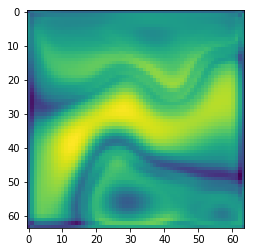

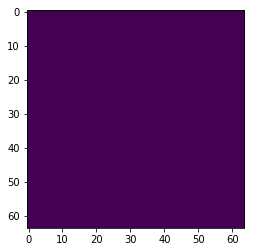

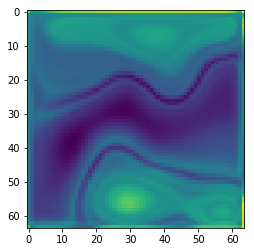

Iter 600 || Loss: 3.4437 || Mask: 3.4166 || Regr: 0.0271
Iter 610 || Loss: 3.5069 || Mask: 3.4622 || Regr: 0.0447
Iter 620 || Loss: 3.6567 || Mask: 3.6214 || Regr: 0.0353
Iter 630 || Loss: 3.6371 || Mask: 3.5898 || Regr: 0.0473
Iter 640 || Loss: 3.4716 || Mask: 3.4352 || Regr: 0.0364
Iter 650 || Loss: 3.2199 || Mask: 3.1840 || Regr: 0.0359
Iter 660 || Loss: 3.7179 || Mask: 3.6654 || Regr: 0.0525
Iter 670 || Loss: 3.5096 || Mask: 3.4766 || Regr: 0.0330
Iter 680 || Loss: 3.4117 || Mask: 3.3709 || Regr: 0.0408
Iter 690 || Loss: 3.7056 || Mask: 3.6631 || Regr: 0.0425


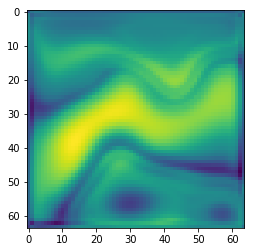

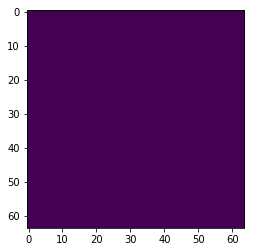

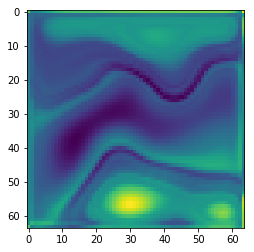

Iter 700 || Loss: 3.3465 || Mask: 3.3139 || Regr: 0.0325
Iter 710 || Loss: 3.4941 || Mask: 3.4584 || Regr: 0.0357
Iter 720 || Loss: 3.4714 || Mask: 3.4377 || Regr: 0.0337
Iter 730 || Loss: 3.4454 || Mask: 3.4114 || Regr: 0.0340
Iter 740 || Loss: 3.5283 || Mask: 3.4871 || Regr: 0.0412
Iter 750 || Loss: 3.6208 || Mask: 3.5758 || Regr: 0.0451
Iter 760 || Loss: 3.5769 || Mask: 3.5247 || Regr: 0.0523
Iter 770 || Loss: 3.2937 || Mask: 3.2549 || Regr: 0.0388
Iter 780 || Loss: 3.3406 || Mask: 3.3088 || Regr: 0.0318
Iter 790 || Loss: 3.2701 || Mask: 3.2384 || Regr: 0.0317


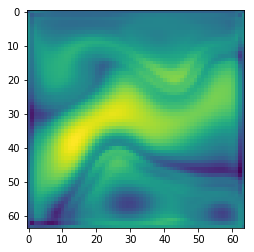

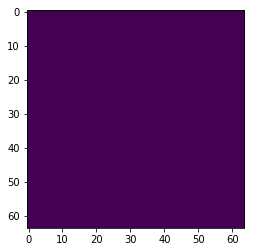

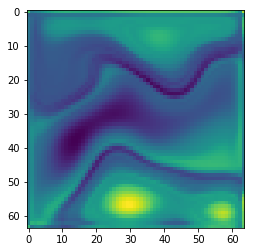

Iter 800 || Loss: 3.4410 || Mask: 3.4079 || Regr: 0.0331
Iter 810 || Loss: 3.6068 || Mask: 3.5627 || Regr: 0.0441
Iter 820 || Loss: 3.7233 || Mask: 3.6546 || Regr: 0.0687
Iter 830 || Loss: 3.5532 || Mask: 3.5168 || Regr: 0.0364
Iter 840 || Loss: 3.1587 || Mask: 3.1280 || Regr: 0.0307
Iter 850 || Loss: 3.3416 || Mask: 3.3053 || Regr: 0.0363
Iter 860 || Loss: 3.5567 || Mask: 3.5202 || Regr: 0.0365
Iter 870 || Loss: 3.5166 || Mask: 3.4716 || Regr: 0.0451
Iter 880 || Loss: 3.7292 || Mask: 3.6897 || Regr: 0.0395
Iter 890 || Loss: 3.2114 || Mask: 3.1785 || Regr: 0.0329


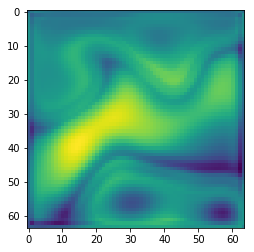

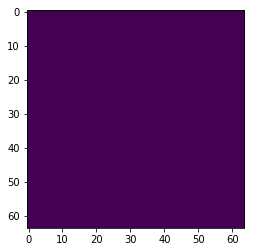

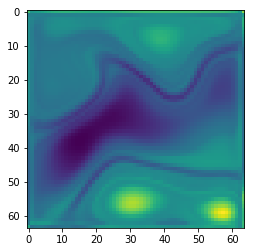

Iter 900 || Loss: 3.5398 || Mask: 3.5036 || Regr: 0.0362
Iter 910 || Loss: 3.7385 || Mask: 3.6981 || Regr: 0.0404
Iter 920 || Loss: 3.1444 || Mask: 3.1085 || Regr: 0.0359
Iter 930 || Loss: 3.3519 || Mask: 3.3187 || Regr: 0.0332
Iter 940 || Loss: 3.3628 || Mask: 3.3331 || Regr: 0.0297
Iter 950 || Loss: 3.3704 || Mask: 3.3302 || Regr: 0.0402
Iter 960 || Loss: 3.2889 || Mask: 3.2422 || Regr: 0.0467
Iter 970 || Loss: 3.6654 || Mask: 3.6325 || Regr: 0.0329
Iter 980 || Loss: 3.1494 || Mask: 3.1155 || Regr: 0.0338
Iter 990 || Loss: 3.1038 || Mask: 3.0789 || Regr: 0.0249


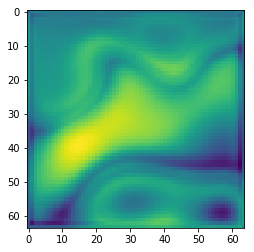

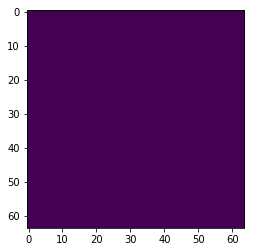

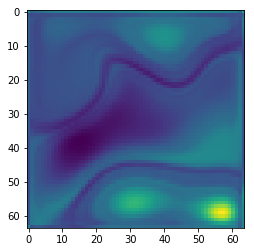

Iter 1000 || Loss: 3.1754 || Mask: 3.1399 || Regr: 0.0354
Iter 1010 || Loss: 3.8075 || Mask: 3.7570 || Regr: 0.0505
Iter 1020 || Loss: 3.3690 || Mask: 3.3310 || Regr: 0.0380
Iter 1030 || Loss: 3.3962 || Mask: 3.3565 || Regr: 0.0397

-------------
(val)



-------------
epoch 2 || Epoch_TRAIN_Loss:1817.7285 ||Epoch_VAL_Loss:537.9008
timer:  189.3144 sec.
lr is: 0.001
-------------
Epoch 3/150
-------------
(train)


Iter 1040 || Loss: 3.4703 || Mask: 3.4267 || Regr: 0.0436
Iter 1050 || Loss: 3.2539 || Mask: 3.2244 || Regr: 0.0295
Iter 1060 || Loss: 3.3488 || Mask: 3.2995 || Regr: 0.0493
Iter 1070 || Loss: 3.4566 || Mask: 3.4179 || Regr: 0.0386
Iter 1080 || Loss: 3.4226 || Mask: 3.3879 || Regr: 0.0347
Iter 1090 || Loss: 2.8108 || Mask: 2.7811 || Regr: 0.0297


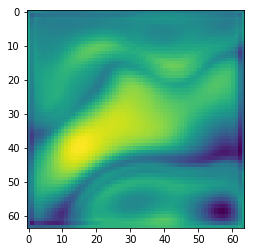

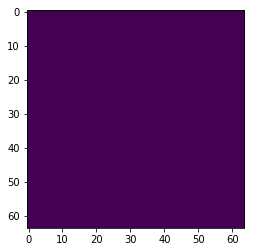

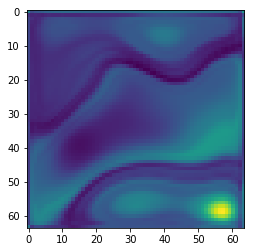

Iter 1100 || Loss: 3.4494 || Mask: 3.4143 || Regr: 0.0351
Iter 1110 || Loss: 3.5496 || Mask: 3.5121 || Regr: 0.0375
Iter 1120 || Loss: 3.3807 || Mask: 3.3348 || Regr: 0.0459
Iter 1130 || Loss: 3.3783 || Mask: 3.3474 || Regr: 0.0308
Iter 1140 || Loss: 3.4941 || Mask: 3.4595 || Regr: 0.0346
Iter 1150 || Loss: 3.4498 || Mask: 3.4173 || Regr: 0.0325
Iter 1160 || Loss: 3.3381 || Mask: 3.3040 || Regr: 0.0341
Iter 1170 || Loss: 3.0132 || Mask: 2.9836 || Regr: 0.0296
Iter 1180 || Loss: 3.4669 || Mask: 3.4249 || Regr: 0.0421
Iter 1190 || Loss: 3.6378 || Mask: 3.6018 || Regr: 0.0359


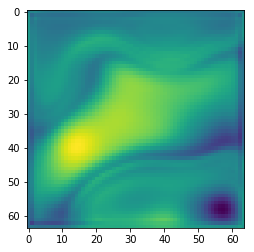

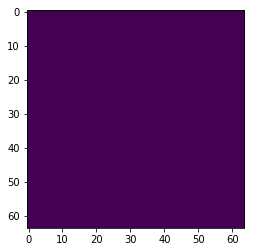

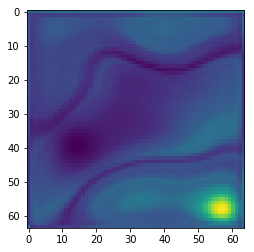

Iter 1200 || Loss: 3.4914 || Mask: 3.4464 || Regr: 0.0450
Iter 1210 || Loss: 3.4765 || Mask: 3.4369 || Regr: 0.0396
Iter 1220 || Loss: 3.3051 || Mask: 3.2761 || Regr: 0.0291
Iter 1230 || Loss: 3.4227 || Mask: 3.3899 || Regr: 0.0328
Iter 1240 || Loss: 3.4819 || Mask: 3.4405 || Regr: 0.0415
Iter 1250 || Loss: 3.6040 || Mask: 3.5587 || Regr: 0.0453
Iter 1260 || Loss: 3.3617 || Mask: 3.3253 || Regr: 0.0365
Iter 1270 || Loss: 3.5342 || Mask: 3.4899 || Regr: 0.0443
Iter 1280 || Loss: 3.6045 || Mask: 3.5655 || Regr: 0.0390
Iter 1290 || Loss: 3.1666 || Mask: 3.1339 || Regr: 0.0327


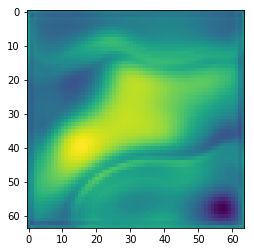

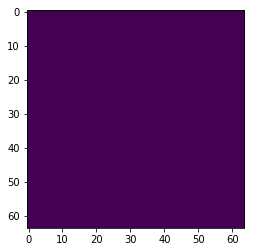

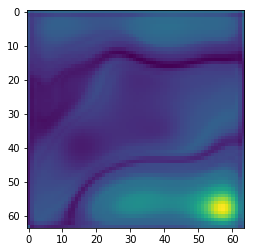

Iter 1300 || Loss: 3.4613 || Mask: 3.4344 || Regr: 0.0269
Iter 1310 || Loss: 3.3725 || Mask: 3.3414 || Regr: 0.0311
Iter 1320 || Loss: 3.4900 || Mask: 3.4490 || Regr: 0.0410
Iter 1330 || Loss: 3.1092 || Mask: 3.0651 || Regr: 0.0441
Iter 1340 || Loss: 3.5209 || Mask: 3.4822 || Regr: 0.0387
Iter 1350 || Loss: 3.5870 || Mask: 3.5212 || Regr: 0.0658
Iter 1360 || Loss: 3.2084 || Mask: 3.1683 || Regr: 0.0401
Iter 1370 || Loss: 3.3985 || Mask: 3.3699 || Regr: 0.0286
Iter 1380 || Loss: 3.3784 || Mask: 3.3448 || Regr: 0.0336
Iter 1390 || Loss: 3.5424 || Mask: 3.5046 || Regr: 0.0378


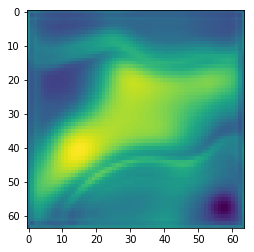

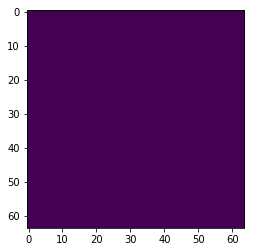

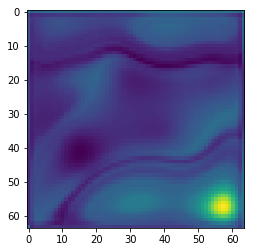

Iter 1400 || Loss: 3.2387 || Mask: 3.2090 || Regr: 0.0297
Iter 1410 || Loss: 3.5002 || Mask: 3.4705 || Regr: 0.0297
Iter 1420 || Loss: 3.4174 || Mask: 3.3826 || Regr: 0.0348
Iter 1430 || Loss: 3.0531 || Mask: 3.0297 || Regr: 0.0235
Iter 1440 || Loss: 3.3894 || Mask: 3.3531 || Regr: 0.0362
Iter 1450 || Loss: 3.4628 || Mask: 3.4271 || Regr: 0.0357
Iter 1460 || Loss: 3.3999 || Mask: 3.3687 || Regr: 0.0312
Iter 1470 || Loss: 3.1496 || Mask: 3.1266 || Regr: 0.0230
Iter 1480 || Loss: 3.3215 || Mask: 3.2848 || Regr: 0.0367
Iter 1490 || Loss: 2.8440 || Mask: 2.8175 || Regr: 0.0264


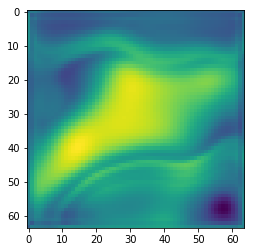

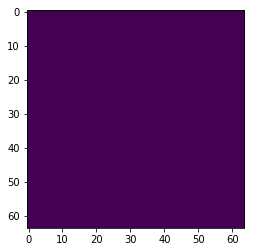

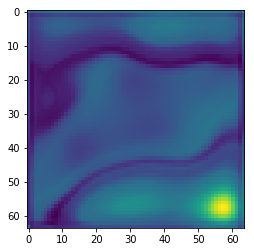

Iter 1500 || Loss: 3.3068 || Mask: 3.2692 || Regr: 0.0376
Iter 1510 || Loss: 3.5847 || Mask: 3.5449 || Regr: 0.0398
Iter 1520 || Loss: 3.3402 || Mask: 3.3027 || Regr: 0.0375
Iter 1530 || Loss: 3.2965 || Mask: 3.2607 || Regr: 0.0358
Iter 1540 || Loss: 3.2542 || Mask: 3.2266 || Regr: 0.0276
Iter 1550 || Loss: 3.2884 || Mask: 3.2489 || Regr: 0.0394

-------------
epoch 3 || Epoch_TRAIN_Loss:1737.7988 ||Epoch_VAL_Loss:0.0000
timer:  179.1018 sec.
lr is: 0.001
-------------
Epoch 4/150
-------------
(train)


Iter 1560 || Loss: 3.2565 || Mask: 3.2227 || Regr: 0.0337
Iter 1570 || Loss: 3.1394 || Mask: 3.1092 || Regr: 0.0302
Iter 1580 || Loss: 3.3286 || Mask: 3.2982 || Regr: 0.0304
Iter 1590 || Loss: 3.2777 || Mask: 3.2449 || Regr: 0.0328


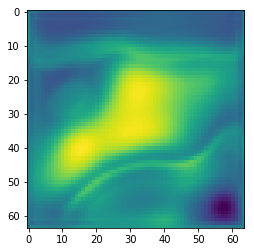

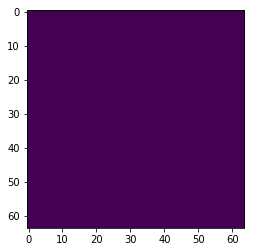

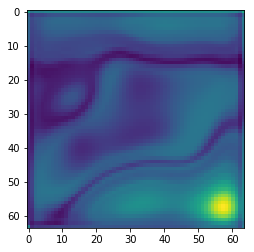

Iter 1600 || Loss: 3.2148 || Mask: 3.1880 || Regr: 0.0268
Iter 1610 || Loss: 3.2526 || Mask: 3.2204 || Regr: 0.0321
Iter 1620 || Loss: 3.3198 || Mask: 3.2947 || Regr: 0.0250
Iter 1630 || Loss: 3.4420 || Mask: 3.4038 || Regr: 0.0382
Iter 1640 || Loss: 3.1790 || Mask: 3.1461 || Regr: 0.0330
Iter 1650 || Loss: 3.3589 || Mask: 3.3232 || Regr: 0.0357
Iter 1660 || Loss: 3.6087 || Mask: 3.5669 || Regr: 0.0418
Iter 1670 || Loss: 3.4888 || Mask: 3.4513 || Regr: 0.0375
Iter 1680 || Loss: 3.1486 || Mask: 3.1230 || Regr: 0.0256
Iter 1690 || Loss: 2.9419 || Mask: 2.9118 || Regr: 0.0301


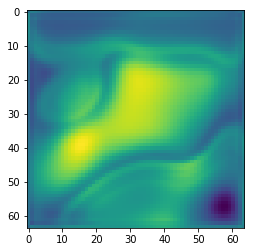

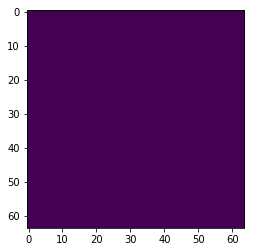

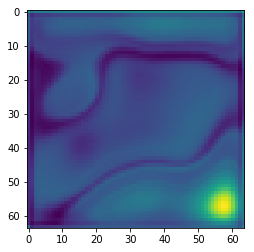

Iter 1700 || Loss: 2.9298 || Mask: 2.8995 || Regr: 0.0303
Iter 1710 || Loss: 3.4646 || Mask: 3.4284 || Regr: 0.0362
Iter 1720 || Loss: 3.0685 || Mask: 3.0433 || Regr: 0.0252
Iter 1730 || Loss: 3.2022 || Mask: 3.1733 || Regr: 0.0289
Iter 1740 || Loss: 2.9664 || Mask: 2.9420 || Regr: 0.0244
Iter 1750 || Loss: 3.2613 || Mask: 3.2335 || Regr: 0.0278
Iter 1760 || Loss: 3.0554 || Mask: 3.0324 || Regr: 0.0231
Iter 1770 || Loss: 3.3221 || Mask: 3.2923 || Regr: 0.0299
Iter 1780 || Loss: 3.0238 || Mask: 2.9909 || Regr: 0.0329
Iter 1790 || Loss: 3.1273 || Mask: 3.0931 || Regr: 0.0342


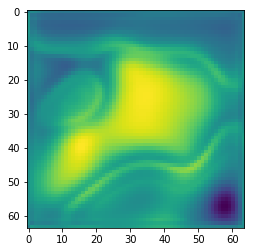

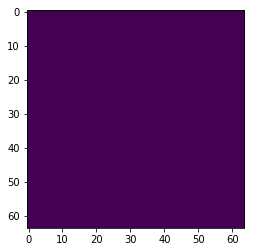

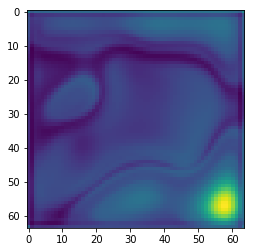

Iter 1800 || Loss: 3.1501 || Mask: 3.1127 || Regr: 0.0373
Iter 1810 || Loss: 3.3422 || Mask: 3.3141 || Regr: 0.0282
Iter 1820 || Loss: 3.1157 || Mask: 3.0950 || Regr: 0.0207
Iter 1830 || Loss: 3.5867 || Mask: 3.5529 || Regr: 0.0339
Iter 1840 || Loss: 3.2711 || Mask: 3.2448 || Regr: 0.0263
Iter 1850 || Loss: 2.9771 || Mask: 2.9476 || Regr: 0.0294
Iter 1860 || Loss: 3.3278 || Mask: 3.3030 || Regr: 0.0249
Iter 1870 || Loss: 3.1293 || Mask: 3.1035 || Regr: 0.0258
Iter 1880 || Loss: 3.1326 || Mask: 3.1107 || Regr: 0.0219
Iter 1890 || Loss: 3.0972 || Mask: 3.0715 || Regr: 0.0258


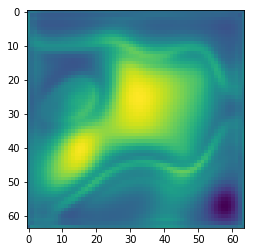

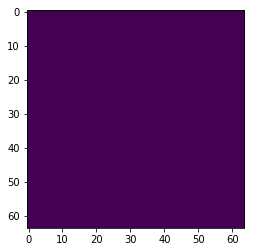

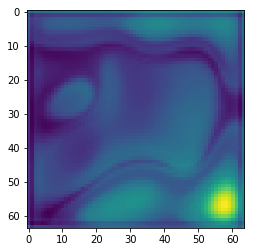

Iter 1900 || Loss: 2.8985 || Mask: 2.8787 || Regr: 0.0197
Iter 1910 || Loss: 3.2618 || Mask: 3.2338 || Regr: 0.0280
Iter 1920 || Loss: 3.0139 || Mask: 2.9935 || Regr: 0.0204
Iter 1930 || Loss: 3.0943 || Mask: 3.0752 || Regr: 0.0191
Iter 1940 || Loss: 3.2259 || Mask: 3.2054 || Regr: 0.0206
Iter 1950 || Loss: 3.1598 || Mask: 3.1331 || Regr: 0.0267
Iter 1960 || Loss: 3.2119 || Mask: 3.1857 || Regr: 0.0263
Iter 1970 || Loss: 3.1683 || Mask: 3.1445 || Regr: 0.0238
Iter 1980 || Loss: 3.1702 || Mask: 3.1513 || Regr: 0.0189
Iter 1990 || Loss: 3.1775 || Mask: 3.1536 || Regr: 0.0239


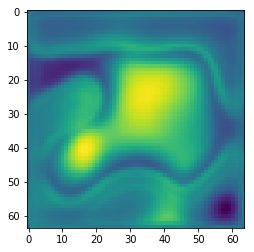

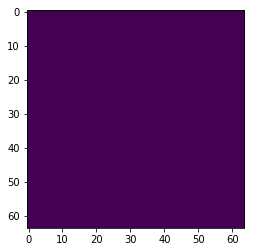

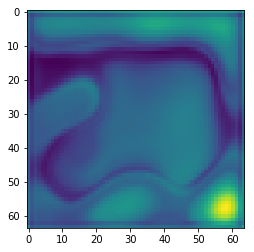

Iter 2000 || Loss: 2.8758 || Mask: 2.8503 || Regr: 0.0254
Iter 2010 || Loss: 2.8557 || Mask: 2.8380 || Regr: 0.0177
Iter 2020 || Loss: 3.1283 || Mask: 3.1001 || Regr: 0.0283
Iter 2030 || Loss: 3.0083 || Mask: 2.9842 || Regr: 0.0241
Iter 2040 || Loss: 3.2702 || Mask: 3.2485 || Regr: 0.0217
Iter 2050 || Loss: 3.3670 || Mask: 3.3426 || Regr: 0.0244
Iter 2060 || Loss: 2.8601 || Mask: 2.8423 || Regr: 0.0178
Iter 2070 || Loss: 3.3639 || Mask: 3.3345 || Regr: 0.0294

-------------
(val)



-------------
epoch 4 || Epoch_TRAIN_Loss:1646.8387 ||Epoch_VAL_Loss:471.0379
timer:  223.1808 sec.
lr is: 0.001
-------------
Epoch 5/150
-------------
(train)


Iter 2080 || Loss: 3.2108 || Mask: 3.1852 || Regr: 0.0255
Iter 2090 || Loss: 3.0836 || Mask: 3.0641 || Regr: 0.0195


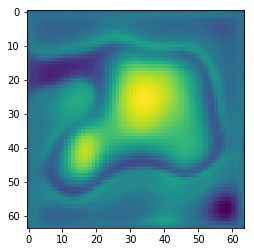

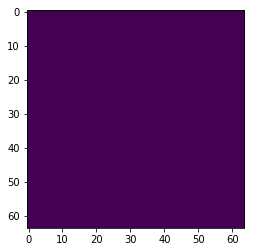

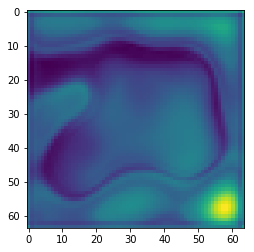

Iter 2100 || Loss: 3.2843 || Mask: 3.2596 || Regr: 0.0247
Iter 2110 || Loss: 3.0214 || Mask: 3.0056 || Regr: 0.0158
Iter 2120 || Loss: 3.0899 || Mask: 3.0620 || Regr: 0.0280
Iter 2130 || Loss: 2.7970 || Mask: 2.7794 || Regr: 0.0176
Iter 2140 || Loss: 2.8297 || Mask: 2.8149 || Regr: 0.0147
Iter 2150 || Loss: 3.3021 || Mask: 3.2814 || Regr: 0.0207
Iter 2160 || Loss: 3.0135 || Mask: 2.9974 || Regr: 0.0161
Iter 2170 || Loss: 3.0827 || Mask: 3.0656 || Regr: 0.0171
Iter 2180 || Loss: 2.8176 || Mask: 2.8040 || Regr: 0.0137
Iter 2190 || Loss: 2.7325 || Mask: 2.7153 || Regr: 0.0172


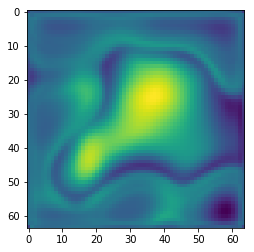

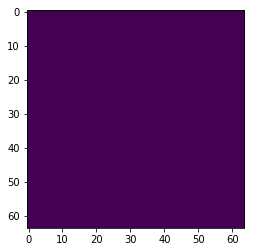

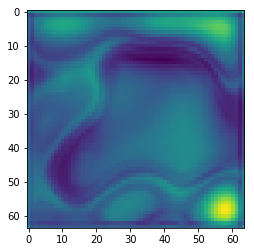

Iter 2200 || Loss: 3.1874 || Mask: 3.1641 || Regr: 0.0233
Iter 2210 || Loss: 3.0761 || Mask: 3.0551 || Regr: 0.0210
Iter 2220 || Loss: 3.0336 || Mask: 3.0072 || Regr: 0.0263
Iter 2230 || Loss: 3.1636 || Mask: 3.1464 || Regr: 0.0171
Iter 2240 || Loss: 3.0099 || Mask: 2.9882 || Regr: 0.0217
Iter 2250 || Loss: 2.7119 || Mask: 2.7000 || Regr: 0.0120
Iter 2260 || Loss: 2.9417 || Mask: 2.9250 || Regr: 0.0167
Iter 2270 || Loss: 2.9008 || Mask: 2.8860 || Regr: 0.0148
Iter 2280 || Loss: 2.9417 || Mask: 2.9159 || Regr: 0.0258
Iter 2290 || Loss: 2.9953 || Mask: 2.9746 || Regr: 0.0207


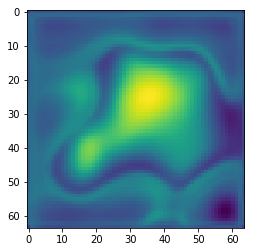

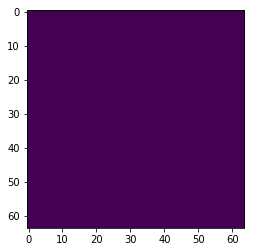

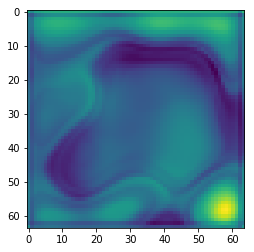

Iter 2300 || Loss: 3.1006 || Mask: 3.0799 || Regr: 0.0207
Iter 2310 || Loss: 2.7318 || Mask: 2.7110 || Regr: 0.0208
Iter 2320 || Loss: 2.6623 || Mask: 2.6429 || Regr: 0.0194
Iter 2330 || Loss: 2.9899 || Mask: 2.9748 || Regr: 0.0151
Iter 2340 || Loss: 2.6704 || Mask: 2.6557 || Regr: 0.0147
Iter 2350 || Loss: 3.0190 || Mask: 2.9986 || Regr: 0.0204
Iter 2360 || Loss: 3.0868 || Mask: 3.0657 || Regr: 0.0211
Iter 2370 || Loss: 3.2158 || Mask: 3.1905 || Regr: 0.0253
Iter 2380 || Loss: 2.7473 || Mask: 2.7256 || Regr: 0.0218
Iter 2390 || Loss: 2.9110 || Mask: 2.8795 || Regr: 0.0316


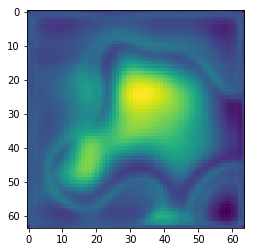

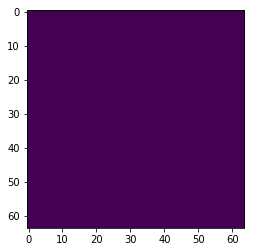

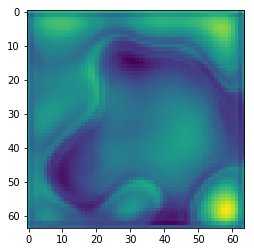

Iter 2400 || Loss: 2.9353 || Mask: 2.9171 || Regr: 0.0182
Iter 2410 || Loss: 2.7368 || Mask: 2.7196 || Regr: 0.0172
Iter 2420 || Loss: 2.8152 || Mask: 2.7980 || Regr: 0.0172
Iter 2430 || Loss: 2.8718 || Mask: 2.8578 || Regr: 0.0141
Iter 2440 || Loss: 2.7853 || Mask: 2.7672 || Regr: 0.0181
Iter 2450 || Loss: 2.9042 || Mask: 2.8825 || Regr: 0.0217
Iter 2460 || Loss: 2.8442 || Mask: 2.8314 || Regr: 0.0128
Iter 2470 || Loss: 2.6634 || Mask: 2.6498 || Regr: 0.0136
Iter 2480 || Loss: 2.5767 || Mask: 2.5607 || Regr: 0.0159
Iter 2490 || Loss: 2.8618 || Mask: 2.8459 || Regr: 0.0159


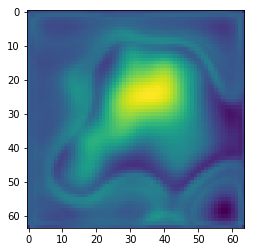

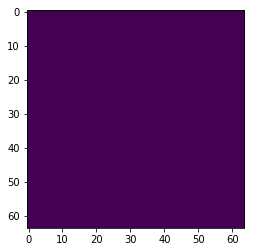

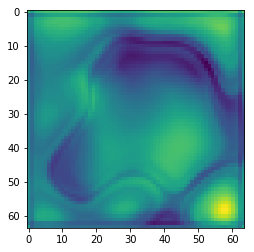

Iter 2500 || Loss: 2.9001 || Mask: 2.8838 || Regr: 0.0164
Iter 2510 || Loss: 2.9681 || Mask: 2.9494 || Regr: 0.0187
Iter 2520 || Loss: 2.5687 || Mask: 2.5533 || Regr: 0.0154
Iter 2530 || Loss: 3.0300 || Mask: 3.0190 || Regr: 0.0110
Iter 2540 || Loss: 2.8682 || Mask: 2.8551 || Regr: 0.0132
Iter 2550 || Loss: 2.6965 || Mask: 2.6834 || Regr: 0.0131
Iter 2560 || Loss: 2.6426 || Mask: 2.6262 || Regr: 0.0164
Iter 2570 || Loss: 2.8176 || Mask: 2.7925 || Regr: 0.0251
Iter 2580 || Loss: 3.0167 || Mask: 2.9963 || Regr: 0.0204
Iter 2590 || Loss: 2.7730 || Mask: 2.7615 || Regr: 0.0115

-------------
epoch 5 || Epoch_TRAIN_Loss:1514.7259 ||Epoch_VAL_Loss:0.0000
timer:  176.8654 sec.
lr is: 0.001
-------------
Epoch 6/150
-------------
(train)


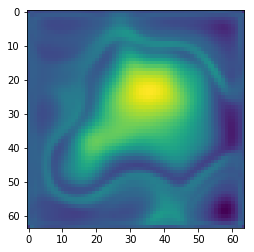

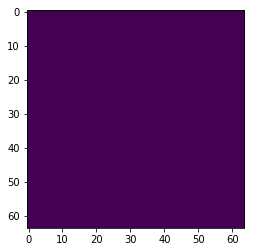

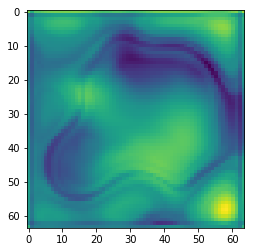

Iter 2600 || Loss: 2.9162 || Mask: 2.8963 || Regr: 0.0199
Iter 2610 || Loss: 2.7815 || Mask: 2.7521 || Regr: 0.0294
Iter 2620 || Loss: 3.0580 || Mask: 3.0338 || Regr: 0.0241
Iter 2630 || Loss: 2.9208 || Mask: 2.9044 || Regr: 0.0164
Iter 2640 || Loss: 2.7050 || Mask: 2.6889 || Regr: 0.0161
Iter 2650 || Loss: 2.7156 || Mask: 2.6956 || Regr: 0.0199
Iter 2660 || Loss: 2.7436 || Mask: 2.7294 || Regr: 0.0142
Iter 2670 || Loss: 2.6353 || Mask: 2.6195 || Regr: 0.0158
Iter 2680 || Loss: 2.9925 || Mask: 2.9744 || Regr: 0.0182
Iter 2690 || Loss: 2.5691 || Mask: 2.5546 || Regr: 0.0145


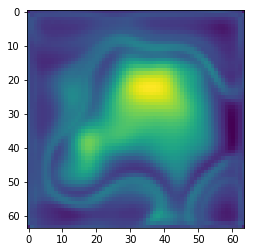

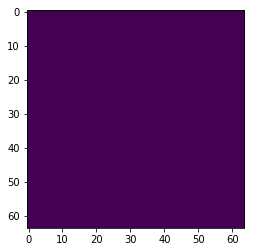

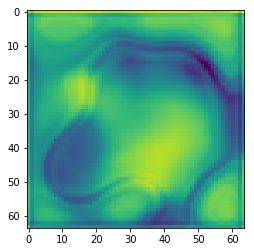

Iter 2700 || Loss: 2.8973 || Mask: 2.8782 || Regr: 0.0191
Iter 2710 || Loss: 2.9341 || Mask: 2.9158 || Regr: 0.0183
Iter 2720 || Loss: 2.4848 || Mask: 2.4668 || Regr: 0.0179
Iter 2730 || Loss: 2.7204 || Mask: 2.6976 || Regr: 0.0228
Iter 2740 || Loss: 2.3671 || Mask: 2.3527 || Regr: 0.0144
Iter 2750 || Loss: 2.7788 || Mask: 2.7638 || Regr: 0.0150
Iter 2760 || Loss: 2.5376 || Mask: 2.5210 || Regr: 0.0166
Iter 2770 || Loss: 2.6146 || Mask: 2.5961 || Regr: 0.0184
Iter 2780 || Loss: 2.8280 || Mask: 2.8082 || Regr: 0.0198
Iter 2790 || Loss: 3.0601 || Mask: 3.0396 || Regr: 0.0205


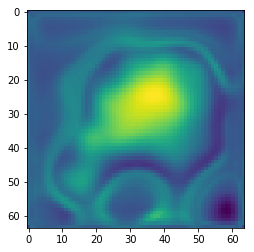

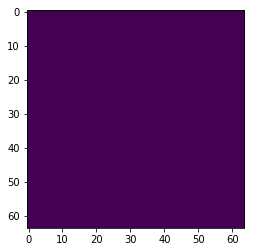

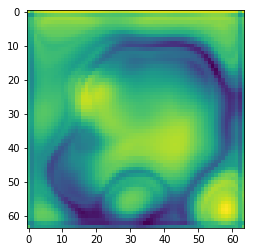

Iter 2800 || Loss: 2.6320 || Mask: 2.6073 || Regr: 0.0247
Iter 2810 || Loss: 2.7191 || Mask: 2.7050 || Regr: 0.0141
Iter 2820 || Loss: 2.7431 || Mask: 2.7282 || Regr: 0.0150
Iter 2830 || Loss: 2.7761 || Mask: 2.7600 || Regr: 0.0162
Iter 2840 || Loss: 2.8410 || Mask: 2.8219 || Regr: 0.0191
Iter 2850 || Loss: 2.7531 || Mask: 2.7387 || Regr: 0.0144
Iter 2860 || Loss: 2.6126 || Mask: 2.5979 || Regr: 0.0146
Iter 2870 || Loss: 3.1347 || Mask: 3.1133 || Regr: 0.0215
Iter 2880 || Loss: 2.9522 || Mask: 2.9354 || Regr: 0.0168
Iter 2890 || Loss: 2.6854 || Mask: 2.6665 || Regr: 0.0189


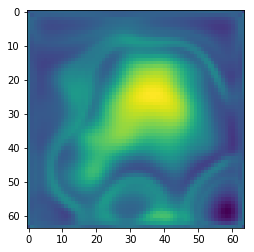

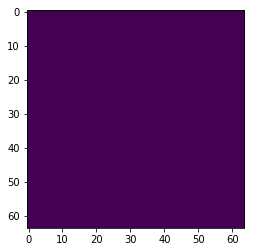

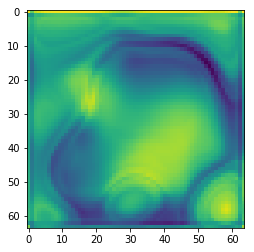

Iter 2900 || Loss: 2.9168 || Mask: 2.8942 || Regr: 0.0226
Iter 2910 || Loss: 2.6597 || Mask: 2.6417 || Regr: 0.0180
Iter 2920 || Loss: 2.8307 || Mask: 2.8122 || Regr: 0.0185
Iter 2930 || Loss: 2.7247 || Mask: 2.7109 || Regr: 0.0138
Iter 2940 || Loss: 2.8772 || Mask: 2.8632 || Regr: 0.0140
Iter 2950 || Loss: 2.6630 || Mask: 2.6415 || Regr: 0.0215
Iter 2960 || Loss: 2.8608 || Mask: 2.8461 || Regr: 0.0147
Iter 2970 || Loss: 2.7610 || Mask: 2.7466 || Regr: 0.0144
Iter 2980 || Loss: 2.8948 || Mask: 2.8735 || Regr: 0.0213
Iter 2990 || Loss: 2.5441 || Mask: 2.5310 || Regr: 0.0131


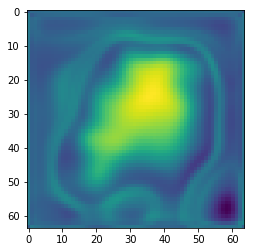

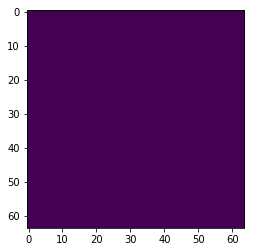

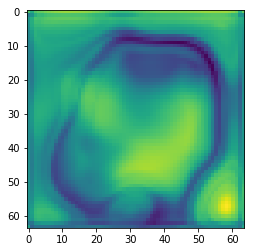

Iter 3000 || Loss: 2.9072 || Mask: 2.8867 || Regr: 0.0205
Iter 3010 || Loss: 2.4956 || Mask: 2.4795 || Regr: 0.0161
Iter 3020 || Loss: 2.8722 || Mask: 2.8518 || Regr: 0.0205
Iter 3030 || Loss: 2.8239 || Mask: 2.8060 || Regr: 0.0179
Iter 3040 || Loss: 3.0309 || Mask: 3.0115 || Regr: 0.0194
Iter 3050 || Loss: 2.5631 || Mask: 2.5485 || Regr: 0.0146
Iter 3060 || Loss: 2.6229 || Mask: 2.6048 || Regr: 0.0181
Iter 3070 || Loss: 2.8018 || Mask: 2.7870 || Regr: 0.0148
Iter 3080 || Loss: 2.8085 || Mask: 2.7935 || Regr: 0.0150
Iter 3090 || Loss: 2.7741 || Mask: 2.7584 || Regr: 0.0157


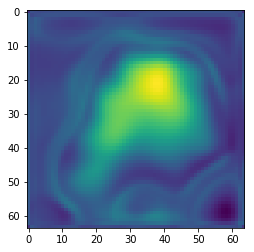

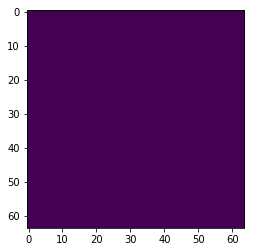

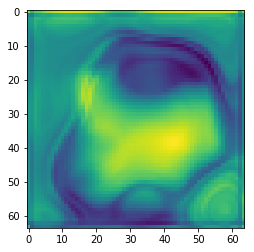

Iter 3100 || Loss: 2.5284 || Mask: 2.5075 || Regr: 0.0209

-------------
(val)



-------------
epoch 6 || Epoch_TRAIN_Loss:1428.0838 ||Epoch_VAL_Loss:424.6574
timer:  202.0559 sec.
lr is: 0.001
-------------
Epoch 7/150
-------------
(train)


Iter 3110 || Loss: 2.7471 || Mask: 2.7245 || Regr: 0.0226
Iter 3120 || Loss: 2.7575 || Mask: 2.7377 || Regr: 0.0198
Iter 3130 || Loss: 2.7703 || Mask: 2.7550 || Regr: 0.0152
Iter 3140 || Loss: 2.6449 || Mask: 2.6276 || Regr: 0.0173
Iter 3150 || Loss: 2.7345 || Mask: 2.7223 || Regr: 0.0122
Iter 3160 || Loss: 2.6258 || Mask: 2.6040 || Regr: 0.0218
Iter 3170 || Loss: 2.8201 || Mask: 2.7979 || Regr: 0.0222
Iter 3180 || Loss: 2.7065 || Mask: 2.6924 || Regr: 0.0141
Iter 3190 || Loss: 2.2688 || Mask: 2.2565 || Regr: 0.0123


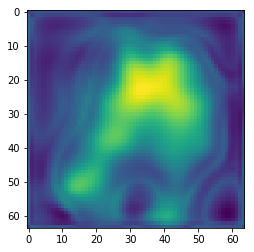

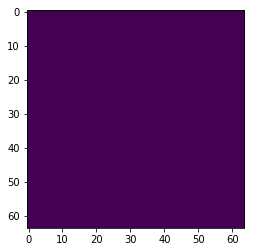

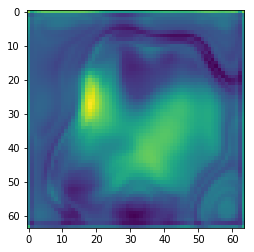

Iter 3200 || Loss: 2.7846 || Mask: 2.7650 || Regr: 0.0196
Iter 3210 || Loss: 2.6562 || Mask: 2.6435 || Regr: 0.0127
Iter 3220 || Loss: 2.4538 || Mask: 2.4419 || Regr: 0.0119
Iter 3230 || Loss: 2.5739 || Mask: 2.5583 || Regr: 0.0157
Iter 3240 || Loss: 2.4769 || Mask: 2.4524 || Regr: 0.0245
Iter 3250 || Loss: 3.0216 || Mask: 2.9961 || Regr: 0.0255
Iter 3260 || Loss: 2.4734 || Mask: 2.4559 || Regr: 0.0175
Iter 3270 || Loss: 2.6206 || Mask: 2.6062 || Regr: 0.0144
Iter 3280 || Loss: 2.4852 || Mask: 2.4678 || Regr: 0.0174
Iter 3290 || Loss: 2.5814 || Mask: 2.5649 || Regr: 0.0164


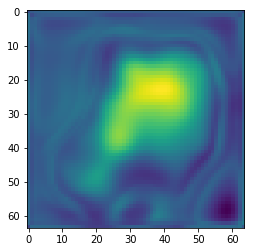

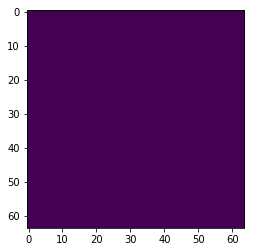

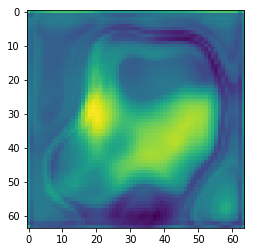

Iter 3300 || Loss: 2.8402 || Mask: 2.8262 || Regr: 0.0140
Iter 3310 || Loss: 2.2808 || Mask: 2.2627 || Regr: 0.0181
Iter 3320 || Loss: 2.7919 || Mask: 2.7759 || Regr: 0.0160
Iter 3330 || Loss: 2.5421 || Mask: 2.5293 || Regr: 0.0127
Iter 3340 || Loss: 2.5836 || Mask: 2.5689 || Regr: 0.0147
Iter 3350 || Loss: 2.5322 || Mask: 2.5158 || Regr: 0.0164
Iter 3360 || Loss: 2.4153 || Mask: 2.3961 || Regr: 0.0192
Iter 3370 || Loss: 2.7789 || Mask: 2.7592 || Regr: 0.0197
Iter 3380 || Loss: 2.6498 || Mask: 2.6340 || Regr: 0.0158
Iter 3390 || Loss: 2.5090 || Mask: 2.4914 || Regr: 0.0177


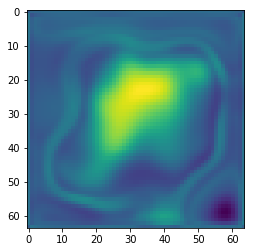

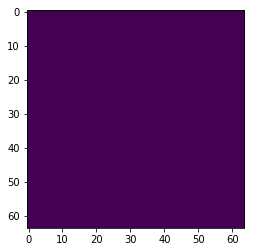

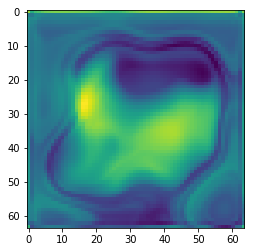

Iter 3400 || Loss: 2.6230 || Mask: 2.6050 || Regr: 0.0180
Iter 3410 || Loss: 2.4314 || Mask: 2.4192 || Regr: 0.0122
Iter 3420 || Loss: 2.7153 || Mask: 2.7030 || Regr: 0.0123
Iter 3430 || Loss: 2.5097 || Mask: 2.4919 || Regr: 0.0178
Iter 3440 || Loss: 2.7474 || Mask: 2.7211 || Regr: 0.0263
Iter 3450 || Loss: 2.5541 || Mask: 2.5345 || Regr: 0.0196
Iter 3460 || Loss: 2.6217 || Mask: 2.6035 || Regr: 0.0182
Iter 3470 || Loss: 2.5736 || Mask: 2.5568 || Regr: 0.0168
Iter 3480 || Loss: 2.4322 || Mask: 2.4095 || Regr: 0.0227
Iter 3490 || Loss: 2.4126 || Mask: 2.3943 || Regr: 0.0184


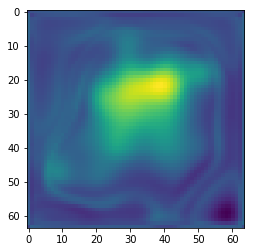

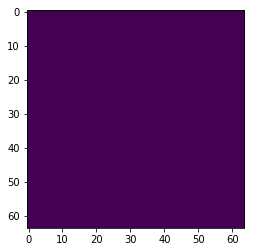

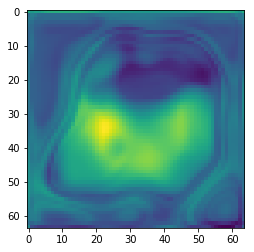

Iter 3500 || Loss: 2.6181 || Mask: 2.6040 || Regr: 0.0140
Iter 3510 || Loss: 2.6563 || Mask: 2.6327 || Regr: 0.0237
Iter 3520 || Loss: 2.5660 || Mask: 2.5497 || Regr: 0.0163
Iter 3530 || Loss: 2.5925 || Mask: 2.5704 || Regr: 0.0221
Iter 3540 || Loss: 2.6849 || Mask: 2.6672 || Regr: 0.0177
Iter 3550 || Loss: 2.6812 || Mask: 2.6639 || Regr: 0.0173
Iter 3560 || Loss: 2.6260 || Mask: 2.6077 || Regr: 0.0183
Iter 3570 || Loss: 2.9637 || Mask: 2.9395 || Regr: 0.0242
Iter 3580 || Loss: 2.5033 || Mask: 2.4895 || Regr: 0.0138
Iter 3590 || Loss: 2.4523 || Mask: 2.4355 || Regr: 0.0169


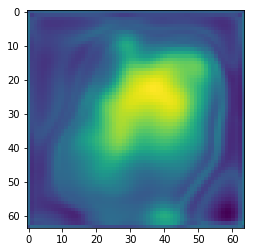

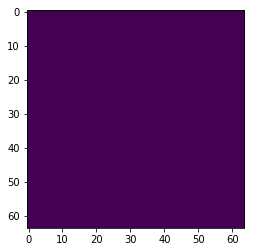

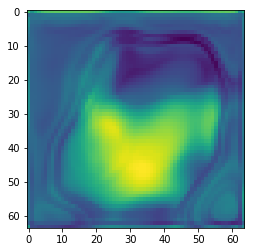

Iter 3600 || Loss: 2.8053 || Mask: 2.7785 || Regr: 0.0268
Iter 3610 || Loss: 2.6175 || Mask: 2.6030 || Regr: 0.0145
Iter 3620 || Loss: 2.6331 || Mask: 2.6192 || Regr: 0.0139

-------------
epoch 7 || Epoch_TRAIN_Loss:1364.7827 ||Epoch_VAL_Loss:0.0000
timer:  169.9041 sec.
lr is: 0.001
-------------
Epoch 8/150
-------------
(train)


Iter 3630 || Loss: 2.4758 || Mask: 2.4566 || Regr: 0.0192
Iter 3640 || Loss: 2.7054 || Mask: 2.6874 || Regr: 0.0181
Iter 3650 || Loss: 2.7721 || Mask: 2.7548 || Regr: 0.0173
Iter 3660 || Loss: 2.7789 || Mask: 2.7605 || Regr: 0.0185
Iter 3670 || Loss: 2.7971 || Mask: 2.7768 || Regr: 0.0202
Iter 3680 || Loss: 2.8366 || Mask: 2.8127 || Regr: 0.0240
Iter 3690 || Loss: 2.5880 || Mask: 2.5714 || Regr: 0.0166


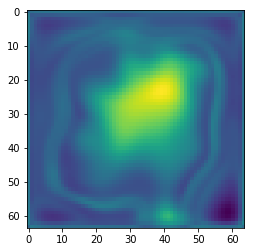

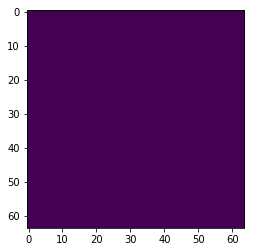

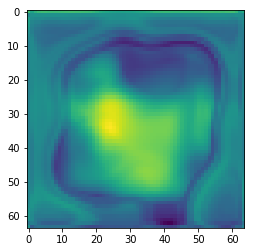

Iter 3700 || Loss: 2.2657 || Mask: 2.2496 || Regr: 0.0161
Iter 3710 || Loss: 2.5749 || Mask: 2.5589 || Regr: 0.0160
Iter 3720 || Loss: 2.4473 || Mask: 2.4320 || Regr: 0.0152
Iter 3730 || Loss: 2.4876 || Mask: 2.4692 || Regr: 0.0184
Iter 3740 || Loss: 2.4660 || Mask: 2.4508 || Regr: 0.0152
Iter 3750 || Loss: 2.5678 || Mask: 2.5500 || Regr: 0.0178
Iter 3760 || Loss: 2.5052 || Mask: 2.4867 || Regr: 0.0186
Iter 3770 || Loss: 2.5639 || Mask: 2.5448 || Regr: 0.0191
Iter 3780 || Loss: 2.5377 || Mask: 2.5190 || Regr: 0.0187
Iter 3790 || Loss: 2.7222 || Mask: 2.6992 || Regr: 0.0230


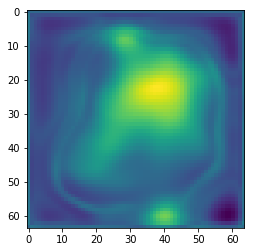

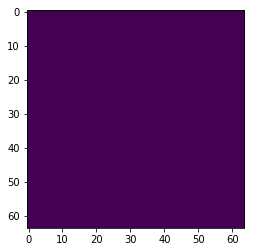

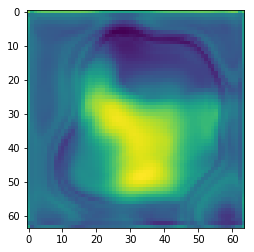

Iter 3800 || Loss: 2.4405 || Mask: 2.4230 || Regr: 0.0174
Iter 3810 || Loss: 2.6294 || Mask: 2.6126 || Regr: 0.0168
Iter 3820 || Loss: 2.5686 || Mask: 2.5493 || Regr: 0.0193
Iter 3830 || Loss: 2.5387 || Mask: 2.5167 || Regr: 0.0219
Iter 3840 || Loss: 2.4885 || Mask: 2.4702 || Regr: 0.0184
Iter 3850 || Loss: 2.5197 || Mask: 2.4933 || Regr: 0.0264
Iter 3860 || Loss: 2.5241 || Mask: 2.4984 || Regr: 0.0256
Iter 3870 || Loss: 2.6752 || Mask: 2.6548 || Regr: 0.0204
Iter 3880 || Loss: 2.4582 || Mask: 2.4403 || Regr: 0.0179
Iter 3890 || Loss: 2.1522 || Mask: 2.1357 || Regr: 0.0165


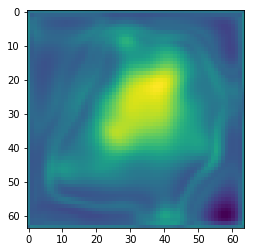

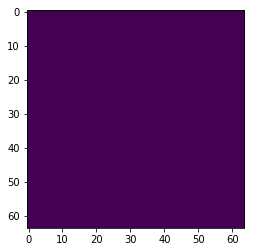

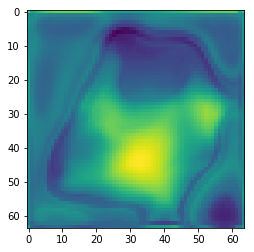

Iter 3900 || Loss: 2.3520 || Mask: 2.3369 || Regr: 0.0151
Iter 3910 || Loss: 2.6941 || Mask: 2.6751 || Regr: 0.0189
Iter 3920 || Loss: 2.5202 || Mask: 2.4964 || Regr: 0.0238
Iter 3930 || Loss: 2.4997 || Mask: 2.4844 || Regr: 0.0153
Iter 3940 || Loss: 2.4749 || Mask: 2.4551 || Regr: 0.0198
Iter 3950 || Loss: 2.7833 || Mask: 2.7595 || Regr: 0.0238
Iter 3960 || Loss: 2.3707 || Mask: 2.3585 || Regr: 0.0122
Iter 3970 || Loss: 2.3913 || Mask: 2.3761 || Regr: 0.0151
Iter 3980 || Loss: 2.3661 || Mask: 2.3507 || Regr: 0.0154
Iter 3990 || Loss: 2.7473 || Mask: 2.7274 || Regr: 0.0199


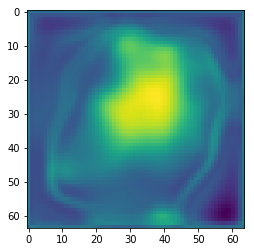

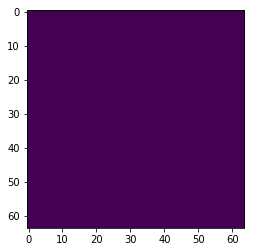

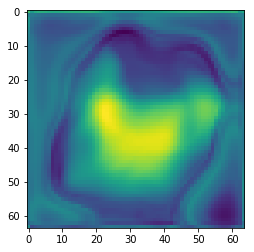

Iter 4000 || Loss: 2.6372 || Mask: 2.6181 || Regr: 0.0191
Iter 4010 || Loss: 2.7369 || Mask: 2.7204 || Regr: 0.0165
Iter 4020 || Loss: 2.5462 || Mask: 2.5234 || Regr: 0.0228
Iter 4030 || Loss: 2.5971 || Mask: 2.5757 || Regr: 0.0214
Iter 4040 || Loss: 2.5696 || Mask: 2.5537 || Regr: 0.0158
Iter 4050 || Loss: 2.4561 || Mask: 2.4354 || Regr: 0.0207
Iter 4060 || Loss: 2.7151 || Mask: 2.6922 || Regr: 0.0229
Iter 4070 || Loss: 2.9564 || Mask: 2.9309 || Regr: 0.0255
Iter 4080 || Loss: 2.5242 || Mask: 2.5097 || Regr: 0.0145
Iter 4090 || Loss: 2.6004 || Mask: 2.5784 || Regr: 0.0221


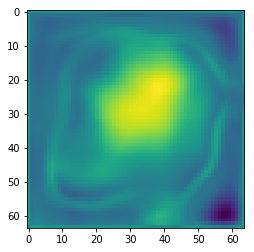

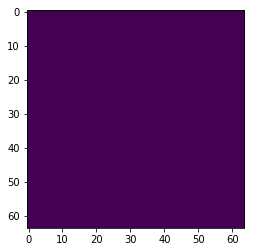

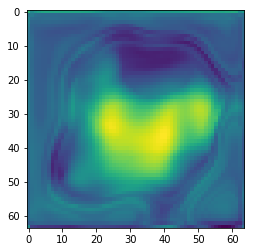

Iter 4100 || Loss: 2.3996 || Mask: 2.3864 || Regr: 0.0132
Iter 4110 || Loss: 2.6448 || Mask: 2.6317 || Regr: 0.0130
Iter 4120 || Loss: 2.7129 || Mask: 2.6918 || Regr: 0.0211
Iter 4130 || Loss: 2.3715 || Mask: 2.3559 || Regr: 0.0155
Iter 4140 || Loss: 2.9099 || Mask: 2.8876 || Regr: 0.0223

-------------
(val)



-------------
epoch 8 || Epoch_TRAIN_Loss:1323.0698 ||Epoch_VAL_Loss:378.7751
timer:  208.3200 sec.
lr is: 0.001
-------------
Epoch 9/150
-------------
(train)


Iter 4150 || Loss: 2.5378 || Mask: 2.5203 || Regr: 0.0175
Iter 4160 || Loss: 2.7355 || Mask: 2.7182 || Regr: 0.0172
Iter 4170 || Loss: 2.4921 || Mask: 2.4783 || Regr: 0.0138
Iter 4180 || Loss: 2.5404 || Mask: 2.5231 || Regr: 0.0173
Iter 4190 || Loss: 2.4001 || Mask: 2.3819 || Regr: 0.0182


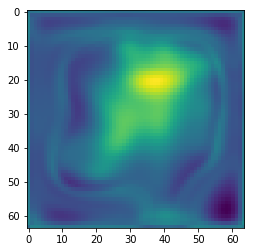

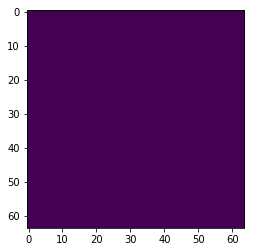

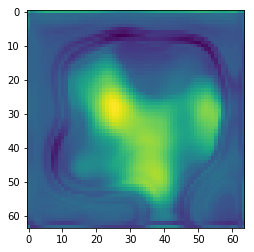

Iter 4200 || Loss: 2.2639 || Mask: 2.2490 || Regr: 0.0149
Iter 4210 || Loss: 2.6388 || Mask: 2.6250 || Regr: 0.0137
Iter 4220 || Loss: 2.0376 || Mask: 2.0206 || Regr: 0.0169
Iter 4230 || Loss: 2.3855 || Mask: 2.3721 || Regr: 0.0134
Iter 4240 || Loss: 2.5537 || Mask: 2.5386 || Regr: 0.0151
Iter 4250 || Loss: 2.5021 || Mask: 2.4843 || Regr: 0.0178
Iter 4260 || Loss: 2.3742 || Mask: 2.3585 || Regr: 0.0156
Iter 4270 || Loss: 2.5743 || Mask: 2.5554 || Regr: 0.0188
Iter 4280 || Loss: 2.5954 || Mask: 2.5798 || Regr: 0.0156
Iter 4290 || Loss: 2.7717 || Mask: 2.7508 || Regr: 0.0208


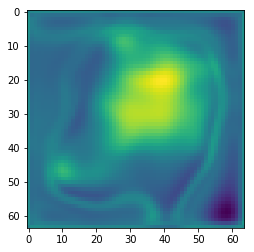

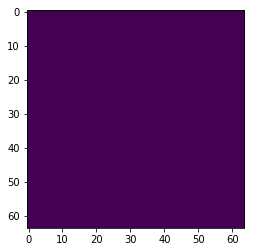

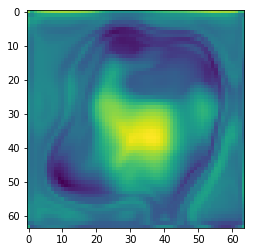

Iter 4300 || Loss: 2.8563 || Mask: 2.8395 || Regr: 0.0168
Iter 4310 || Loss: 2.6118 || Mask: 2.5921 || Regr: 0.0197
Iter 4320 || Loss: 2.6299 || Mask: 2.6134 || Regr: 0.0164
Iter 4330 || Loss: 2.3083 || Mask: 2.2923 || Regr: 0.0160
Iter 4340 || Loss: 2.7734 || Mask: 2.7549 || Regr: 0.0185
Iter 4350 || Loss: 2.3939 || Mask: 2.3780 || Regr: 0.0159
Iter 4360 || Loss: 2.4755 || Mask: 2.4607 || Regr: 0.0148
Iter 4370 || Loss: 2.3879 || Mask: 2.3712 || Regr: 0.0167
Iter 4380 || Loss: 2.8526 || Mask: 2.8350 || Regr: 0.0176
Iter 4390 || Loss: 2.6279 || Mask: 2.6111 || Regr: 0.0168


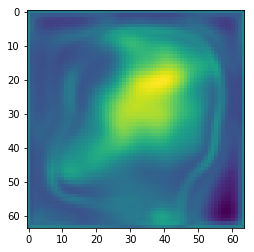

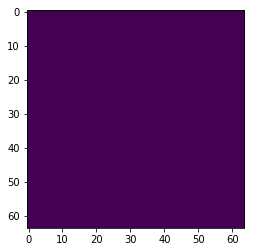

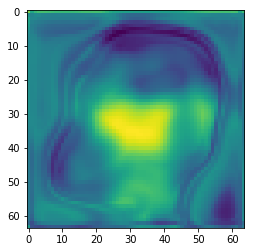

Iter 4400 || Loss: 2.1685 || Mask: 2.1584 || Regr: 0.0101
Iter 4410 || Loss: 2.5177 || Mask: 2.4929 || Regr: 0.0248
Iter 4420 || Loss: 2.1864 || Mask: 2.1687 || Regr: 0.0176
Iter 4430 || Loss: 2.3961 || Mask: 2.3834 || Regr: 0.0127
Iter 4440 || Loss: 2.5835 || Mask: 2.5667 || Regr: 0.0168
Iter 4450 || Loss: 2.3564 || Mask: 2.3420 || Regr: 0.0144
Iter 4460 || Loss: 2.4432 || Mask: 2.4272 || Regr: 0.0161
Iter 4470 || Loss: 2.2836 || Mask: 2.2671 || Regr: 0.0165
Iter 4480 || Loss: 2.7374 || Mask: 2.7185 || Regr: 0.0188
Iter 4490 || Loss: 2.4452 || Mask: 2.4267 || Regr: 0.0184


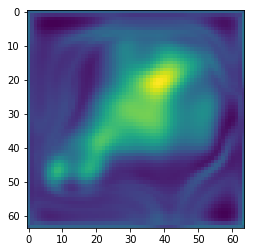

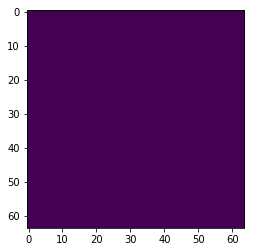

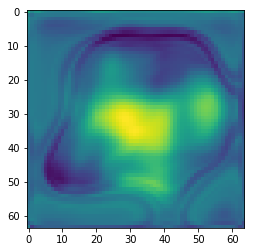

Iter 4500 || Loss: 2.3879 || Mask: 2.3747 || Regr: 0.0132
Iter 4510 || Loss: 2.3959 || Mask: 2.3787 || Regr: 0.0172
Iter 4520 || Loss: 2.5692 || Mask: 2.5548 || Regr: 0.0144
Iter 4530 || Loss: 2.4166 || Mask: 2.4001 || Regr: 0.0165
Iter 4540 || Loss: 2.3050 || Mask: 2.2926 || Regr: 0.0124
Iter 4550 || Loss: 2.2521 || Mask: 2.2392 || Regr: 0.0129
Iter 4560 || Loss: 2.3767 || Mask: 2.3638 || Regr: 0.0130
Iter 4570 || Loss: 2.1989 || Mask: 2.1834 || Regr: 0.0155
Iter 4580 || Loss: 2.3625 || Mask: 2.3452 || Regr: 0.0173
Iter 4590 || Loss: 2.2413 || Mask: 2.2295 || Regr: 0.0119


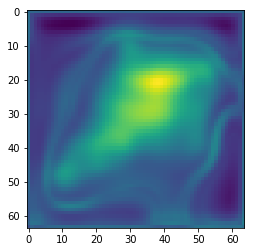

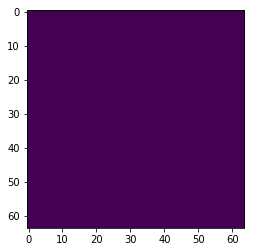

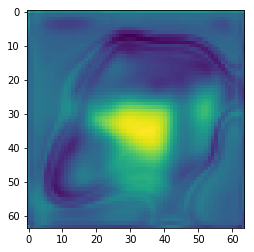

Iter 4600 || Loss: 2.5196 || Mask: 2.5077 || Regr: 0.0119
Iter 4610 || Loss: 2.4852 || Mask: 2.4630 || Regr: 0.0222
Iter 4620 || Loss: 2.6812 || Mask: 2.6638 || Regr: 0.0174
Iter 4630 || Loss: 2.4348 || Mask: 2.4231 || Regr: 0.0117
Iter 4640 || Loss: 2.3100 || Mask: 2.2976 || Regr: 0.0124
Iter 4650 || Loss: 2.4370 || Mask: 2.4147 || Regr: 0.0222
Iter 4660 || Loss: 2.5261 || Mask: 2.5115 || Regr: 0.0146

-------------
epoch 9 || Epoch_TRAIN_Loss:1281.1375 ||Epoch_VAL_Loss:0.0000
timer:  165.0553 sec.
lr is: 0.001
-------------
Epoch 10/150
-------------
(train)


Iter 4670 || Loss: 2.2782 || Mask: 2.2646 || Regr: 0.0135
Iter 4680 || Loss: 2.4088 || Mask: 2.3924 || Regr: 0.0164
Iter 4690 || Loss: 2.2444 || Mask: 2.2281 || Regr: 0.0163


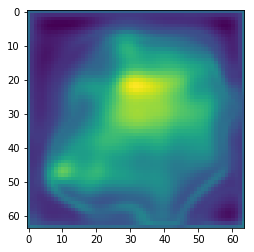

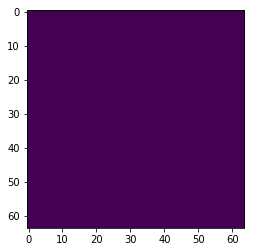

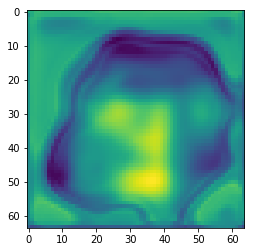

Iter 4700 || Loss: 2.5133 || Mask: 2.4984 || Regr: 0.0149
Iter 4710 || Loss: 2.2442 || Mask: 2.2314 || Regr: 0.0128
Iter 4720 || Loss: 2.7475 || Mask: 2.7299 || Regr: 0.0176
Iter 4730 || Loss: 2.3703 || Mask: 2.3556 || Regr: 0.0147
Iter 4740 || Loss: 2.3091 || Mask: 2.2875 || Regr: 0.0215
Iter 4750 || Loss: 2.2619 || Mask: 2.2493 || Regr: 0.0127
Iter 4760 || Loss: 2.4088 || Mask: 2.3809 || Regr: 0.0279
Iter 4770 || Loss: 2.4119 || Mask: 2.3900 || Regr: 0.0219
Iter 4780 || Loss: 2.5882 || Mask: 2.5631 || Regr: 0.0250
Iter 4790 || Loss: 2.3339 || Mask: 2.3165 || Regr: 0.0174


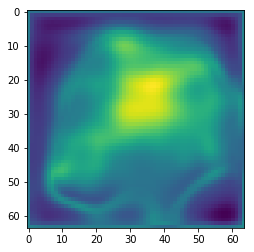

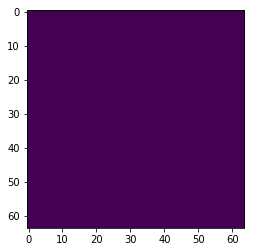

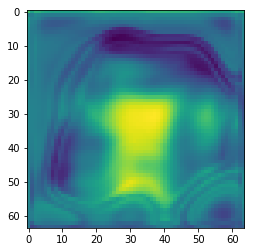

Iter 4800 || Loss: 2.3192 || Mask: 2.3072 || Regr: 0.0120
Iter 4810 || Loss: 2.4086 || Mask: 2.3934 || Regr: 0.0152
Iter 4820 || Loss: 2.1559 || Mask: 2.1400 || Regr: 0.0160
Iter 4830 || Loss: 2.3641 || Mask: 2.3529 || Regr: 0.0112
Iter 4840 || Loss: 2.1642 || Mask: 2.1535 || Regr: 0.0107
Iter 4850 || Loss: 2.6074 || Mask: 2.5869 || Regr: 0.0205
Iter 4860 || Loss: 2.5803 || Mask: 2.5613 || Regr: 0.0190
Iter 4870 || Loss: 2.6787 || Mask: 2.6599 || Regr: 0.0188
Iter 4880 || Loss: 2.4407 || Mask: 2.4243 || Regr: 0.0164
Iter 4890 || Loss: 2.6826 || Mask: 2.6637 || Regr: 0.0190


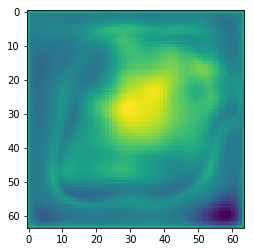

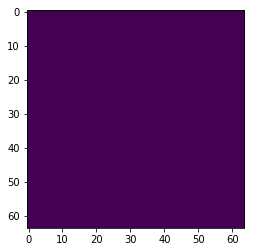

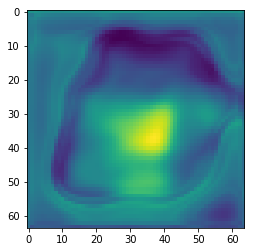

Iter 4900 || Loss: 2.3384 || Mask: 2.3240 || Regr: 0.0144
Iter 4910 || Loss: 2.2324 || Mask: 2.2194 || Regr: 0.0130
Iter 4920 || Loss: 2.4075 || Mask: 2.3922 || Regr: 0.0153
Iter 4930 || Loss: 2.9054 || Mask: 2.8900 || Regr: 0.0154
Iter 4940 || Loss: 2.5286 || Mask: 2.5116 || Regr: 0.0170
Iter 4950 || Loss: 2.2539 || Mask: 2.2390 || Regr: 0.0149
Iter 4960 || Loss: 2.5044 || Mask: 2.4878 || Regr: 0.0166
Iter 4970 || Loss: 2.3732 || Mask: 2.3576 || Regr: 0.0157
Iter 4980 || Loss: 2.2683 || Mask: 2.2556 || Regr: 0.0127
Iter 4990 || Loss: 2.5210 || Mask: 2.5027 || Regr: 0.0183


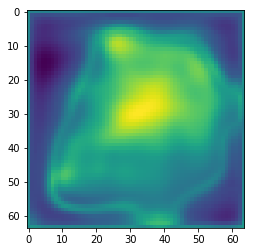

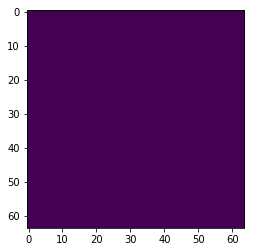

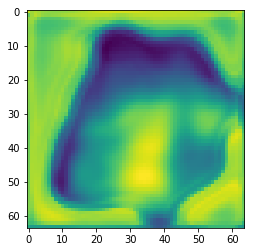

Iter 5000 || Loss: 2.2504 || Mask: 2.2374 || Regr: 0.0130
Iter 5010 || Loss: 2.5467 || Mask: 2.5315 || Regr: 0.0152
Iter 5020 || Loss: 2.0932 || Mask: 2.0782 || Regr: 0.0151
Iter 5030 || Loss: 2.4848 || Mask: 2.4723 || Regr: 0.0125
Iter 5040 || Loss: 2.5854 || Mask: 2.5682 || Regr: 0.0172
Iter 5050 || Loss: 2.5589 || Mask: 2.5396 || Regr: 0.0193
Iter 5060 || Loss: 2.7167 || Mask: 2.6863 || Regr: 0.0304
Iter 5070 || Loss: 2.3079 || Mask: 2.2867 || Regr: 0.0213
Iter 5080 || Loss: 2.3555 || Mask: 2.3372 || Regr: 0.0183
Iter 5090 || Loss: 2.3911 || Mask: 2.3748 || Regr: 0.0163


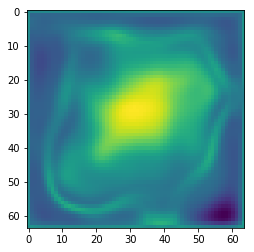

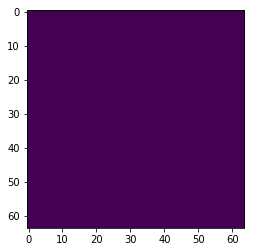

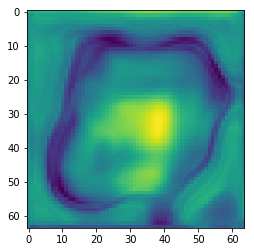

Iter 5100 || Loss: 2.4960 || Mask: 2.4804 || Regr: 0.0156
Iter 5110 || Loss: 2.4847 || Mask: 2.4689 || Regr: 0.0157
Iter 5120 || Loss: 2.5623 || Mask: 2.5460 || Regr: 0.0163
Iter 5130 || Loss: 2.3828 || Mask: 2.3640 || Regr: 0.0188
Iter 5140 || Loss: 2.3441 || Mask: 2.3282 || Regr: 0.0159
Iter 5150 || Loss: 2.8536 || Mask: 2.8378 || Regr: 0.0158
Iter 5160 || Loss: 2.4189 || Mask: 2.3941 || Regr: 0.0248
Iter 5170 || Loss: 2.2052 || Mask: 2.1903 || Regr: 0.0149
Iter 5180 || Loss: 2.4171 || Mask: 2.4030 || Regr: 0.0141

-------------
(val)


In [ ]:
num_epochs = 150
torch.cuda.empty_cache()
train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)